In [1]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
plt_save_path = '../result/WSHR/figures'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [60]:
# 数据集构建

# 读取采样的npy文件
sample_save_path = '../Dataset/Samples/sampling_data_array.npy'
# os.chmod(sample_save_path, stat.S_IRWXU)
sampling_data_array = np.load(sample_save_path)

# k-fold分割训练集和测试集
k = 10
segments = np.array_split(sampling_data_array, k, axis=1)

def datasetConstruct(segments, test_idx):
    f_seg_array, b_seg_array = np.array(segments[:test_idx]), np.array(segments[-(k-1-test_idx):])
    print(f_seg_array.shape)
    print(b_seg_array.shape)
    train_dataset = np.concatenate((f_seg_array, b_seg_array), axis=1)
    test_dataset = segments[test_idx]
    # train_X, train_Y = train_dataset[1:], train_dataset[0]
    # test_X, test_Y = test_dataset[1:], test_dataset[0]
    return np.squeeze(train_dataset), np.squeeze(test_dataset)

In [48]:
tmp = [1,2,3]
print(tmp[:0])
print(tmp[-1:])

[]
[3]


In [61]:
# 构建MLP
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 给定数据存储路径
mlp_save_path = '../result/variable_evaluate/mlp'
if not os.path.exists(mlp_save_path):
    os.mkdir(mlp_save_path)
accuracy_save_path = os.path.join(mlp_save_path, 'accuracy')
loss_save_path = os.path.join(mlp_save_path, 'loss')
if not os.path.exists(accuracy_save_path):
    os.mkdir(accuracy_save_path)
if not os.path.exists(loss_save_path):
    os.mkdir(loss_save_path)

# 创建权重记录列表
weights_record_list = []

# 定义每个batch的大小
batch_size = 10

def mlpFit(train_dataset, test_dataset, test_idx):
    print(train_dataset.shape)

    # 计算总的batch数量
    num_batches = len(train_dataset) // batch_size

    # 随机打乱数据集的索引
    indices = np.random.permutation(len(train_dataset))

    train_X, train_Y = train_dataset[1:].T, train_dataset[0]
    test_X, test_Y = test_dataset[1:].T, test_dataset[0]

    # 特征标准化处理
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    # 创建MLP回归器实例
    mlp = MLPRegressor(hidden_layer_sizes = (100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.01, verbose=False)
    # mlp_list = []

    # 按照每个batch逐批训练
    for i in range(num_batches):

        # 获取当前batch的索引
        batch_indices = indices[i * batch_size: (i + 1) * batch_size]

        # 获取当前batch的数据
        batch_X = train_X_scaled[batch_indices]
        batch_Y = train_Y[batch_indices]

        # 逐批训练模型
        mlp.partial_fit(batch_X, batch_Y)
        loss_values = mlp.loss_curve_
        print(f"train complete in batch {i}")

        # 调用回调函数
        weights = mlp.coefs_
        weights_record_list.append(weights)

    # 测试模型
    y_pred = mlp.predict(test_X_scaled)
    # for i in range(y_pred.shape[1]):
    #     plt.figure()
    #     plt.plot(y_pred[:,i], label='Predicted')
    #     plt.plot(test_Y[:,i], label='Actual')
    #     plt.show()
    print("test complete")

    # 评估模型的性能
    accuracy = mlp.score(test_X_scaled, test_Y)
    print("evaluate complete")

    if True:
        # 打印模型性能
        print("模型性能：", accuracy)
        plt.figure()
        plt.plot(y_pred, label='Predicted')
        plt.plot(test_Y, label='Actual')
        plt.title('WSHR -- Predicted vs Actual')
        plt.savefig(os.path.join(accuracy_save_path, 'WSHR_accuracy_%d.png'%test_idx))
        plt.show()
        # 可视化损失值的变化
        plt.figure()
        plt.plot(loss_values, label='Training Loss')
        plt.title('WSHR -- Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(loss_save_path, 'WSHR_loss_%d.png'%test_idx))
        plt.show()

for i in range(k):
    train_dataset, test_dataset = datasetConstruct(segments, i)
    mlpFit(train_dataset, test_dataset, i)
    # break

C:\Users\86108\AppData\Local\Temp\ipykernel_157816\3064683352.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_seg_array, b_seg_array = np.array(segments[:test_idx]), np.array(segments[-(k-1-test_idx):])


ValueError: could not broadcast input array from shape (164,22396,1) into shape (164,)

In [3]:
# give the preset classification of determined variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "ABRK", "NSQT",
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", "TH", 
                       "TAS", "CASM", "GS",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = [
                   "FADS", 
                   
                   "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL",
                   "LGDN"]
var_group_control = ["HDGS", "PTRM", 
                     "RUDP", "CCPC", "CCPF", "CWPC", "CWPF",
                     "SNAP", 
                     "GPWS", "SHKR", "FADF"]
var_group_external = ["ALT", "WS", "WD", "PT", "TAT",
                      "LOC"]
var_group_recorder = ["PH"
                     ]
var_group_unclassified = ["EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "SMKB"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

mechanism: 25
power: 11
control: 11
external: 6
recorder: 1
unclassified: 7

61 variables in total


In [8]:
'''
检查所有预选变量在原始数据中的完整性，筛选出能保证全变量完整的子数据集作为MLP的训练集和测试集；
以训练的MLP对原始数据进行数据补正，以供之后通过随机森林在WSHR的二分类问题上对特征变量进行再次评估，以迭代出新的预选变量集
'''

# 检查预选变量数据完整性并生成工作子集
def check_var_integrity(mat, download_folder_path, mat_name):
    for group_name, var_group in var_groups_dict.items():
        for var_name in var_group:
            if np.mean(mat[var_name][0][0][0]) == 0 and np.var(mat[var_name][0][0][0]) == 0:
                # print(f"{var_name} in {group_name} is empty")
                # print(f"Jump mat {mat_name}")
                return False
    print(f"Receive mat {download_folder_path}: {mat_name}")
    return True

work_dict = {}
# for exception_folder_path in exception_folder_paths:
#     for exception_mat_name in os.listdir(exception_folder_path):
#         e_mat = loadmat(os.path.join(exception_folder_path, exception_mat_name))
#         if check_var_integrity(e_mat, exception_mat_name):
#             work_dict[exception_mat_name] = e_mat
'''
Received matname: []
'''

for download_folder_path in download_folder_paths:
    for download_mat_name in os.listdir(download_folder_path):
        d_mat = loadmat(os.path.join(download_folder_path, download_mat_name))
        if check_var_integrity(d_mat, download_folder_path, download_mat_name):
            work_dict[download_mat_name] = d_mat
'''
Received matname: ['653200212291431.mat', '660200210081101.mat','686200105101854.mat']
'''

np.save("../result/variable_evaluate/work_dict.npy", work_dict)

Receive mat 653200212291431.mat
Receive mat 660200210081101.mat
Receive mat 686200105101854.mat


In [15]:
# 统计存在数据缺失的所有变量，设置为待补完变量
invalid_var_dict = {}
for group_name, var_group in var_groups_dict.items():
    invalid_var_list = []
    for var_name in var_group:
        print(f"Checking {var_name} in {group_name} ...")
        break_flag = False
        # for download_folder_path in download_folder_paths:
        #     print(f"Arrive at folder {download_folder_path.split('/')[-1]}")
        #     for download_mat_name in os.listdir(download_folder_path):
        #         d_mat = loadmat(os.path.join(download_folder_path, download_mat_name))
        #         if np.mean(d_mat[var_name][0][0][0]) == 0 and np.var(d_mat[var_name][0][0][0]) == 0:
        #             invalid_var_list.append(var_name)
        #             print(f"----- {var_name} in {group_name} is invalid -----")
        #             break_flag = True
        #             break
        #     if break_flag:
        #         break
        for exception_folder_path in exception_folder_paths:
            # print(f"Arrive at folder {exception_folder_path.split('/')[-1]}")
            for exception_mat_name in os.listdir(exception_folder_path):
                e_mat = loadmat(os.path.join(exception_folder_path, exception_mat_name))
                if np.mean(e_mat[var_name][0][0][0]) == 0 and np.var(e_mat[var_name][0][0][0]) == 0:
                    invalid_var_list.append(var_name)
                    print(f"----- {var_name} in {group_name} is invalid -----")
                    break_flag = True
                    break
            if break_flag:
                break
    invalid_var_dict[group_name] = invalid_var_list

Checking AIL_1 in mechanism ...
Checking AIL_2 in mechanism ...
Checking FLAP in mechanism ...
----- FLAP in mechanism is invalid -----
Checking ELEV_1 in mechanism ...
Checking ELEV_2 in mechanism ...
Checking RUDD in mechanism ...
Checking SPL_1 in mechanism ...
Checking SPL_2 in mechanism ...
Checking SPLG in mechanism ...
----- SPLG in mechanism is invalid -----
Checking SPLY in mechanism ...
----- SPLY in mechanism is invalid -----
Checking ABRK in mechanism ...
Checking BPGR_1 in mechanism ...
----- BPGR_1 in mechanism is invalid -----
Checking BPGR_2 in mechanism ...
----- BPGR_2 in mechanism is invalid -----
Checking BPYR_1 in mechanism ...
----- BPYR_1 in mechanism is invalid -----
Checking BPYR_2 in mechanism ...
----- BPYR_2 in mechanism is invalid -----
Checking MSQT_1 in mechanism ...
----- MSQT_1 in mechanism is invalid -----
Checking MSQT_2 in mechanism ...
----- MSQT_2 in mechanism is invalid -----
Checking NSQT in mechanism ...
----- NSQT in mechanism is invalid -----


In [4]:
invalid_var_dict = {'mechanism': ['FLAP', 'SPLG', 'SPLY', 'BPGR_1', 'BPGR_2', 'BPYR_1', 'BPYR_2', 'MSQT_1', 'MSQT_2', 'NSQT', 'BLV', 'CALT', 'PACK', 'WOW', 'AOA1', 'AOA2', 'GLS', 'PTCH', 'ROLL', 'TH', 'MH', 'TAS', 'CASM', 'GS', 'IVV', 'FPAC', 'CTAC'], \
                    'power': ['N2_1', 'N2_2', 'N2_3', 'N2_4', 'ECYC_1', 'ECYC_2', 'ECYC_3', 'ECYC_4', 'EHRS_1', 'EHRS_2', 'EHRS_3', 'EHRS_4', 'VIB_1', 'VIB_2', 'VIB_3', 'VIB_4', 'FADS', 'HYDG', 'HYDY', 'N1_1', 'N1_2', 'N1_3', 'N1_4', 'N1T', 'FF_1', 'FF_2', 'FF_3', 'FF_4', 'FQTY_1', 'FQTY_2', 'FQTY_3', 'FQTY_4', 'OIP_1', 'OIP_2', 'OIP_3', 'OIP_4', 'OIPL', 'EGT_1', 'EGT_2', 'EGT_3', 'EGT_4', 'LGDN', 'LGUP'], \
                        'control': ['CRSS', 'HDGS', 'A_T', 'APFD', 'DFGS', 'FGC3', 'PUSH', 'TCAS', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF', 'PLA_1', 'PLA_2', 'PLA_3', 'PLA_4', 'SNAP', 'TMODE', 'EAI', 'TAI', 'WAI_1', 'WAI_2', 'APUF', 'FADF', 'FIRE_1', 'FIRE_2', 'FIRE_3', 'FIRE_4', 'MW', 'POVT', 'SHKR', 'SMOK', 'TOCW'], \
                            'external': ['ALT', 'ALTR', 'WS', 'WD', 'PI', 'PS', 'PT', 'SAT', 'TAT', 'DA', 'TRK', 'TRKM', 'LOC', 'LATP'], \
                                'recorder': ['DWPT', 'PH', 'GMT_HOUR', 'GMT_MINUTE', 'GMT_SEC'], \
                                    'unclassified': ['ATEN', 'EVNT', 'HF1', 'HF2', 'VHF1', 'VHF2', 'VHF3', 'LMOD', 'VMODE', 'MACH', 'MNS', 'MRK', 'N1C', 'N1CO', 'SMKB']}

invalid_var_dict = {'mechanism': ['FLAP', 'SPLG', 'NSQT', 'AOA1', 'AOA2', 'GLS', 'PTCH', 'ROLL', 'TH', 'TAS', 'CASM', 'GS', 'FPAC', 'CTAC'], \
                    'power': ['FADS', 'FQTY_1', 'FQTY_2', 'FQTY_3', 'FQTY_4', 'OIPL', 'LGDN'], \
                        'control': ['HDGS', 'RUDP', 'CCPC', 'CCPF', 'CWPC', 'CWPF', 'SNAP', 'SHKR', 'FADF'], \
                            'external': ['ALT', 'WS', 'WD', 'PT', 'TAT', 'LOC'], 'recorder': ['PH'], \
                                'unclassified': ['EVNT', 'HF1', 'HF2', 'VHF1', 'VHF2', 'VHF3', 'SMKB']}
invalid_group_lens_dict = {}
for group_name, var_group in invalid_var_dict.items():
    invalid_group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(invalid_group_lens_dict.values())} invalid variables in total\n")

valid_var_dict = {group_name: list(set(var_groups_dict[group_name]) - set(invalid_var_dict[group_name])) for group_name in var_groups_dict.keys()}
valid_group_lens_dict = {}
for group_name, var_group in valid_var_dict.items():
    valid_group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(valid_group_lens_dict.values())} valid variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

mechanism: 14
power: 7
control: 9
external: 6
recorder: 1
unclassified: 7

44 invalid variables in total

mechanism: 11
power: 4
control: 2
external: 0
recorder: 0
unclassified: 0

17 valid variables in total


In [5]:
# 构建训练集和测试集

# 给定解释变量中需要排除的变量列表
# exclude_var_list = ['FLAP', 'FQTY_2', 'HDGS', 'TAT', 'LOC', 'PH']
exclude_var_list = []

def minMaxNormalization(data):
    Min = np.min(data, axis=0)
    Max = np.max(data, axis=0)
    Mean = np.mean(data, axis=0)
    Std = np.std(data, axis=0)
    if (Std != 0).all():
        data = (data - Min) / (Max - Min)
    return data

def datasetConstruction(mat):
    X_array, Y_array = [], []
    response_wshr_array = mat["WSHR"][0][0][0]
    # 依据WSHR变量对各变量进行过采样或下采样，以实现张量化
    for group_name, var_list in var_groups_dict.items():
        for var_name in var_list:
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            if var_rate == 1:
                # X_array.append(var_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(var_data[1:])
                if var_name not in exclude_var_list:
                    X_array.append(var_data[:-1])
            elif var_rate > 1: # 进行下采样
                # print(len(var_data.tolist()))
                sampling_data = random.sample(var_data.tolist(), k=len(response_wshr_array))
                # X_array.append(sampling_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(sampling_data[1:])
                if var_name not in exclude_var_list:
                    X_array.append(sampling_data[:-1])
            else:
                sampling_data = random.choices(var_data, k=len(response_wshr_array))
                # X_array.append(sampling_data[:-1])
                if var_name in invalid_var_dict[group_name]:
                    Y_array.append(sampling_data[1:])
                if var_name not in exclude_var_list:
                    X_array.append(sampling_data[:-1])
    X_array = np.squeeze(np.array(X_array)).T
    Y_array = np.squeeze(np.array(Y_array)).T
    # Y_array = np.array(response_wshr_array[:-1])
    # Y_array = Y_array[:,0:1]

    # # 对解释变量和响应变量进行max-min正则化
    # X_array = minMaxNormalization(X_array)
    # Y_array = minMaxNormalization(Y_array)

    return [X_array, Y_array]

complete_mat_list = ['Tail_653_5/653200212291431.mat', 'Tail_660_5/660200210081101.mat','Tail_686_1/686200105101854.mat']

train_X, train_Y = [np.concatenate((datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[0])))[i], \
                                  datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[1])))[i]), axis=0) for i in range(2)]
print(train_X.shape, train_Y.shape)

test_X, test_Y = datasetConstruction(loadmat(os.path.join(download_save_path, complete_mat_list[2])))
print(test_X.shape, test_Y.shape)

NameError: name 'download_save_path' is not defined

===== Checking mechanism: FLAP =====
Iteration 1, loss = 353398.42230591
Iteration 2, loss = 186624.19215895
Iteration 3, loss = 122569.58916044
Iteration 4, loss = 113988.10326487
Iteration 5, loss = 101397.60750929
Iteration 6, loss = 93351.71857324
Iteration 7, loss = 85984.06091050
Iteration 8, loss = 78703.90688031
Iteration 9, loss = 70782.88616805
Iteration 10, loss = 63242.95776654
Iteration 11, loss = 57035.97545482
Iteration 12, loss = 50813.73511677
Iteration 13, loss = 45414.41883517
Iteration 14, loss = 40288.51898680
Iteration 15, loss = 36156.21611441
Iteration 16, loss = 33803.14172962
Iteration 17, loss = 30503.66790253
Iteration 18, loss = 26688.97254566
Iteration 19, loss = 24365.51264054
Iteration 20, loss = 22026.34944792
Iteration 21, loss = 21510.63027635
Iteration 22, loss = 19644.26997180
Iteration 23, loss = 17575.16488174
Iteration 24, loss = 15616.16633198
Iteration 25, loss = 14914.81806041
Iteration 26, loss = 13924.37364794
Iteration 27, loss = 14177.2810

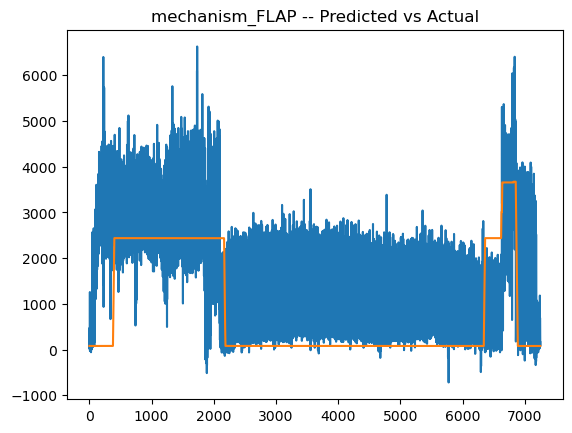

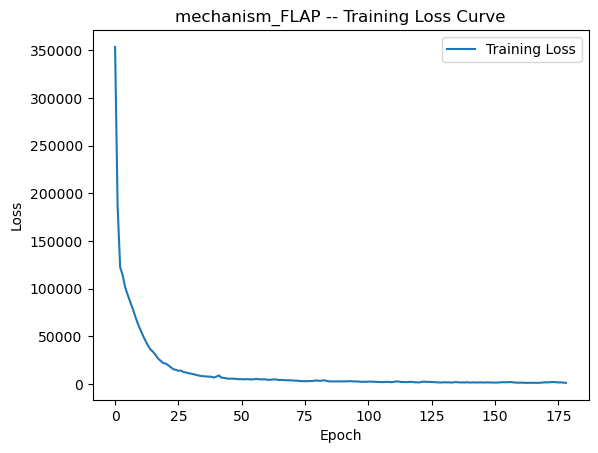

===== Checking mechanism: SPLG =====
Iteration 1, loss = 0.07847195
Iteration 2, loss = 0.01989320
Iteration 3, loss = 0.02348030
Iteration 4, loss = 0.00211723
Iteration 5, loss = 0.00149759
Iteration 6, loss = 0.00109146
Iteration 7, loss = 0.00088314
Iteration 8, loss = 0.00073371
Iteration 9, loss = 0.00064280
Iteration 10, loss = 0.00056338
Iteration 11, loss = 0.00051219
Iteration 12, loss = 0.00048301
Iteration 13, loss = 0.00042305
Iteration 14, loss = 0.00040981
Iteration 15, loss = 0.00040154
Iteration 16, loss = 0.00035573
Iteration 17, loss = 0.00034269
Iteration 18, loss = 0.00031764
Iteration 19, loss = 0.00030190
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -21.965068968386834


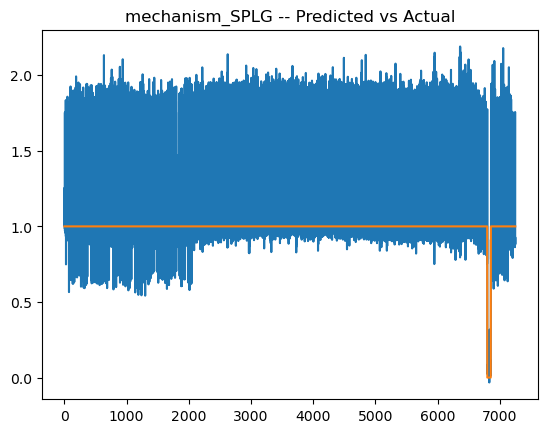

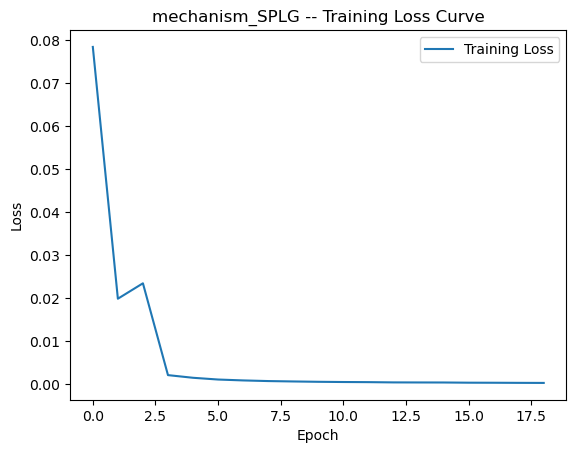

===== Checking mechanism: NSQT =====
Iteration 1, loss = 0.14777450
Iteration 2, loss = 0.09080461
Iteration 3, loss = 0.09892949
Iteration 4, loss = 0.07792017
Iteration 5, loss = 0.07714103
Iteration 6, loss = 0.07672690
Iteration 7, loss = 0.07537644
Iteration 8, loss = 0.07472832
Iteration 9, loss = 0.07344550
Iteration 10, loss = 0.07287943
Iteration 11, loss = 0.07274146
Iteration 12, loss = 0.07188366
Iteration 13, loss = 0.07107362
Iteration 14, loss = 0.07080415
Iteration 15, loss = 0.07078795
Iteration 16, loss = 0.07075498
Iteration 17, loss = 0.06905158
Iteration 18, loss = 0.06805861
Iteration 19, loss = 0.06901003
Iteration 20, loss = 0.06688694
Iteration 21, loss = 0.06730059
Iteration 22, loss = 0.06626162
Iteration 23, loss = 0.06507363
Iteration 24, loss = 0.06852227
Iteration 25, loss = 0.06585149
Iteration 26, loss = 0.06488105
Iteration 27, loss = 0.06310312
Iteration 28, loss = 0.06278018
Iteration 29, loss = 0.06185630
Iteration 30, loss = 0.06191632
Iteration 31

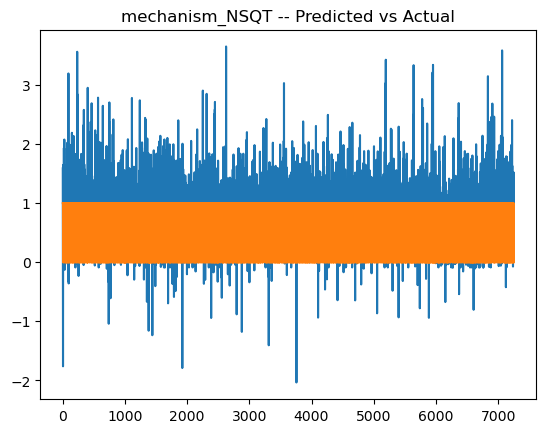

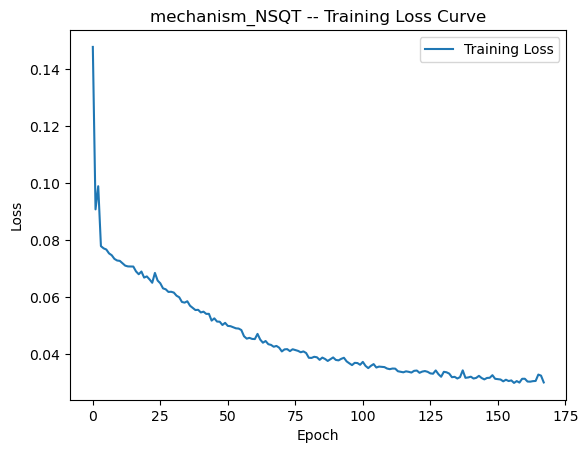

===== Checking mechanism: AOA1 =====
Iteration 1, loss = 2.53999783
Iteration 2, loss = 2.22879060
Iteration 3, loss = 2.20563939
Iteration 4, loss = 2.19684713
Iteration 5, loss = 2.17794966
Iteration 6, loss = 2.15210506
Iteration 7, loss = 2.13747214
Iteration 8, loss = 2.11784340
Iteration 9, loss = 2.11913400
Iteration 10, loss = 2.09218088
Iteration 11, loss = 2.05745173
Iteration 12, loss = 2.04544859
Iteration 13, loss = 2.02295932
Iteration 14, loss = 2.01499284
Iteration 15, loss = 1.99040010
Iteration 16, loss = 1.98321565
Iteration 17, loss = 1.94717904
Iteration 18, loss = 1.92059863
Iteration 19, loss = 1.92765651
Iteration 20, loss = 1.88872953
Iteration 21, loss = 1.84721567
Iteration 22, loss = 1.83779330
Iteration 23, loss = 1.82522841
Iteration 24, loss = 1.77150383
Iteration 25, loss = 1.75858273
Iteration 26, loss = 1.73763335
Iteration 27, loss = 1.69461582
Iteration 28, loss = 1.69562288
Iteration 29, loss = 1.65947581
Iteration 30, loss = 1.61915267
Iteration 31

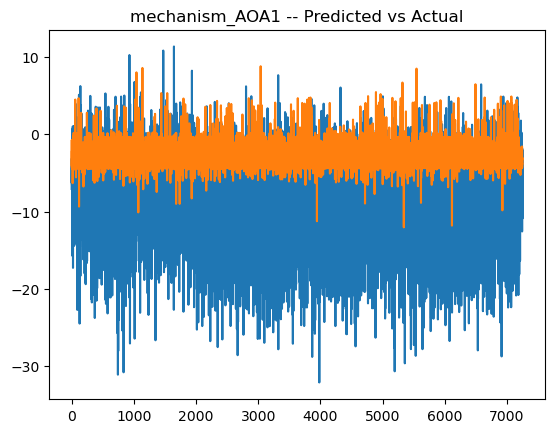

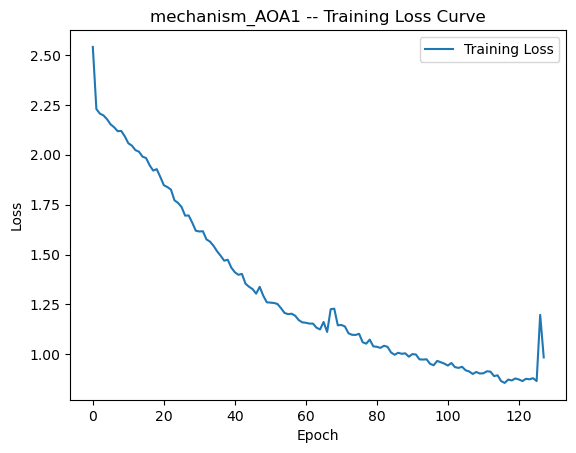

===== Checking mechanism: AOA2 =====
Iteration 1, loss = 1.96528188
Iteration 2, loss = 1.56498020
Iteration 3, loss = 1.54546830
Iteration 4, loss = 1.53244411
Iteration 5, loss = 1.50452939
Iteration 6, loss = 1.50128460
Iteration 7, loss = 1.47628094
Iteration 8, loss = 1.47875684
Iteration 9, loss = 1.43899595
Iteration 10, loss = 1.44849698
Iteration 11, loss = 1.42291977
Iteration 12, loss = 1.42849419
Iteration 13, loss = 1.40154118
Iteration 14, loss = 1.37639301
Iteration 15, loss = 1.36214977
Iteration 16, loss = 1.34903571
Iteration 17, loss = 1.34166381
Iteration 18, loss = 1.31234888
Iteration 19, loss = 1.30546108
Iteration 20, loss = 1.28758647
Iteration 21, loss = 1.26270917
Iteration 22, loss = 1.25797698
Iteration 23, loss = 1.25304299
Iteration 24, loss = 1.22664341
Iteration 25, loss = 1.23717937
Iteration 26, loss = 1.23045649
Iteration 27, loss = 1.20000757
Iteration 28, loss = 1.16582591
Iteration 29, loss = 1.14111666
Iteration 30, loss = 1.12829199
Iteration 31

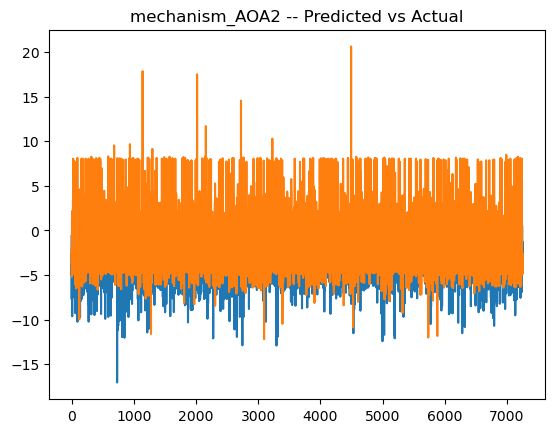

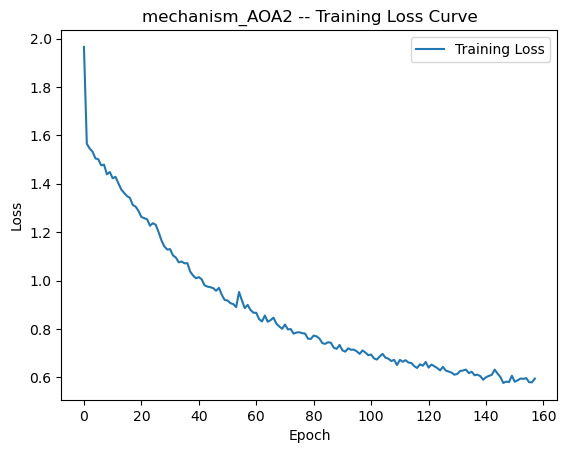

===== Checking mechanism: GLS =====
Iteration 1, loss = 0.03705323
Iteration 2, loss = 0.00340722
Iteration 3, loss = 0.00208072
Iteration 4, loss = 0.00164743
Iteration 5, loss = 0.00150368
Iteration 6, loss = 0.00141446
Iteration 7, loss = 0.00133157
Iteration 8, loss = 0.00126752
Iteration 9, loss = 0.00121468
Iteration 10, loss = 0.00117851
Iteration 11, loss = 0.00115476
Iteration 12, loss = 0.00112321
Iteration 13, loss = 0.00110598
Iteration 14, loss = 0.00108179
Iteration 15, loss = 0.00105671
Iteration 16, loss = 0.00104947
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -4.980853918596777


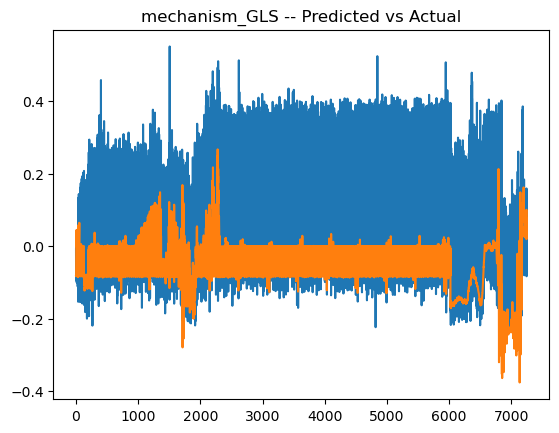

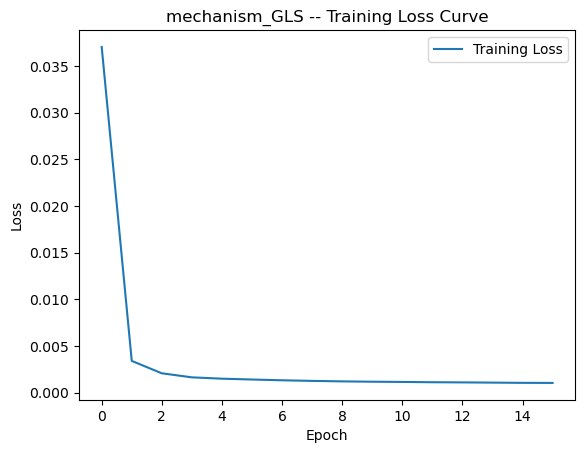

===== Checking mechanism: PTCH =====
Iteration 1, loss = 3.59762517
Iteration 2, loss = 3.36667207
Iteration 3, loss = 3.31992146
Iteration 4, loss = 3.29564437
Iteration 5, loss = 3.25954014
Iteration 6, loss = 3.24073042
Iteration 7, loss = 3.21400768
Iteration 8, loss = 3.15303149
Iteration 9, loss = 3.14265224
Iteration 10, loss = 3.09384696
Iteration 11, loss = 3.08225618
Iteration 12, loss = 3.03316746
Iteration 13, loss = 3.00270584
Iteration 14, loss = 2.95937495
Iteration 15, loss = 2.92559311
Iteration 16, loss = 2.87982789
Iteration 17, loss = 2.86890521
Iteration 18, loss = 2.79082975
Iteration 19, loss = 2.72123311
Iteration 20, loss = 2.70677905
Iteration 21, loss = 2.66266328
Iteration 22, loss = 2.58550314
Iteration 23, loss = 2.54862987
Iteration 24, loss = 2.51339605
Iteration 25, loss = 2.46690829
Iteration 26, loss = 2.42178462
Iteration 27, loss = 2.33286753
Iteration 28, loss = 2.35296995
Iteration 29, loss = 2.28899716
Iteration 30, loss = 2.25568937
Iteration 31

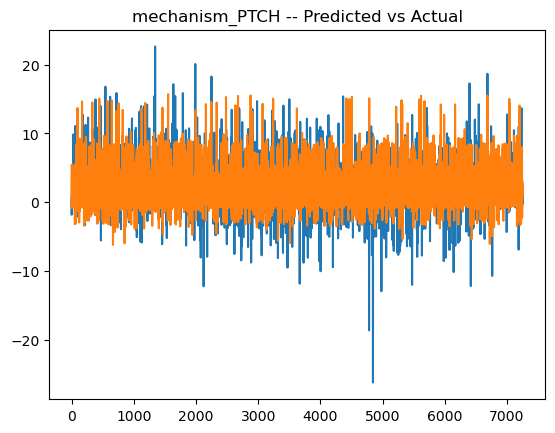

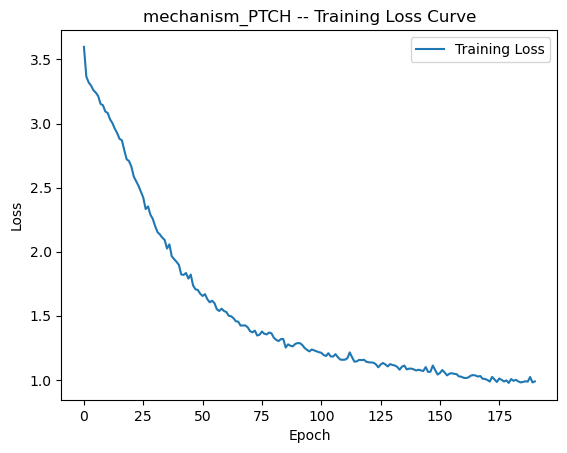

===== Checking mechanism: ROLL =====
Iteration 1, loss = 10.57463446
Iteration 2, loss = 10.46430160
Iteration 3, loss = 10.43212862
Iteration 4, loss = 10.37633155
Iteration 5, loss = 10.33230773
Iteration 6, loss = 10.24643134
Iteration 7, loss = 10.16058342
Iteration 8, loss = 9.95211160
Iteration 9, loss = 9.89767076
Iteration 10, loss = 9.71365500
Iteration 11, loss = 9.40786921
Iteration 12, loss = 9.19492426
Iteration 13, loss = 8.94953559
Iteration 14, loss = 8.57638142
Iteration 15, loss = 8.27090371
Iteration 16, loss = 8.32171307
Iteration 17, loss = 7.96830015
Iteration 18, loss = 7.66365991
Iteration 19, loss = 7.23382315
Iteration 20, loss = 6.89285971
Iteration 21, loss = 6.81003801
Iteration 22, loss = 6.67514827
Iteration 23, loss = 6.62680603
Iteration 24, loss = 6.30433646
Iteration 25, loss = 6.11789453
Iteration 26, loss = 5.94972597
Iteration 27, loss = 5.75560836
Iteration 28, loss = 5.57496982
Iteration 29, loss = 5.46332634
Iteration 30, loss = 5.26024038
Itera

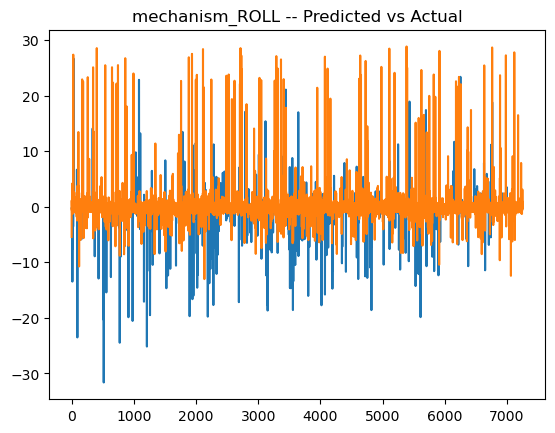

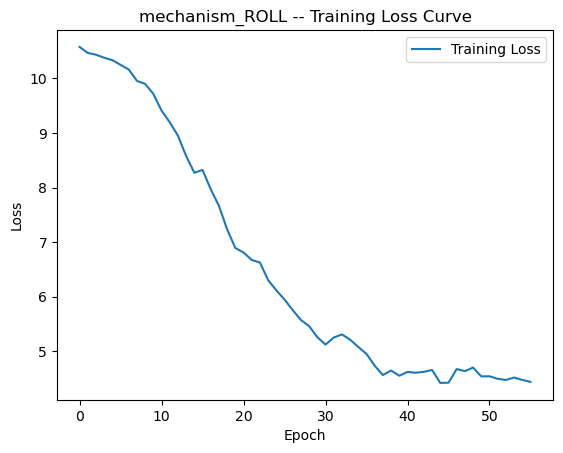

===== Checking mechanism: TH =====
Iteration 1, loss = 2181.77064568
Iteration 2, loss = 1797.99521041
Iteration 3, loss = 1777.60062211
Iteration 4, loss = 1757.73351571
Iteration 5, loss = 1747.16418650
Iteration 6, loss = 1744.06498750
Iteration 7, loss = 1750.44925755
Iteration 8, loss = 1734.43967848
Iteration 9, loss = 1734.41883160
Iteration 10, loss = 1730.70885144
Iteration 11, loss = 1724.00311434
Iteration 12, loss = 1720.16659373
Iteration 13, loss = 1712.34089707
Iteration 14, loss = 1713.20778596
Iteration 15, loss = 1715.96290931
Iteration 16, loss = 1715.76777789
Iteration 17, loss = 1705.16443625
Iteration 18, loss = 1712.40525391
Iteration 19, loss = 1700.09209517
Iteration 20, loss = 1692.79515649
Iteration 21, loss = 1693.85960903
Iteration 22, loss = 1684.03465893
Iteration 23, loss = 1689.51676509
Iteration 24, loss = 1672.49307708
Iteration 25, loss = 1672.22089617
Iteration 26, loss = 1669.51196360
Iteration 27, loss = 1671.57397560
Iteration 28, loss = 1650.004

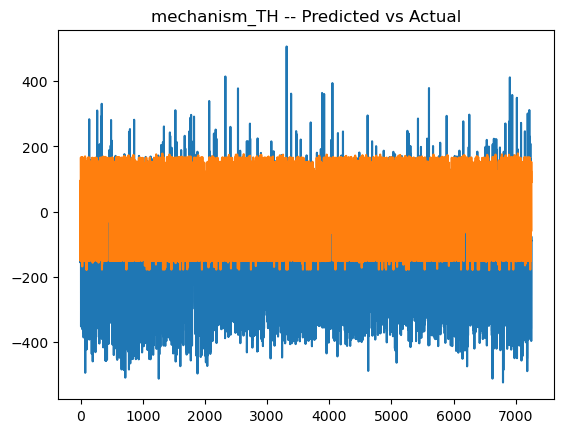

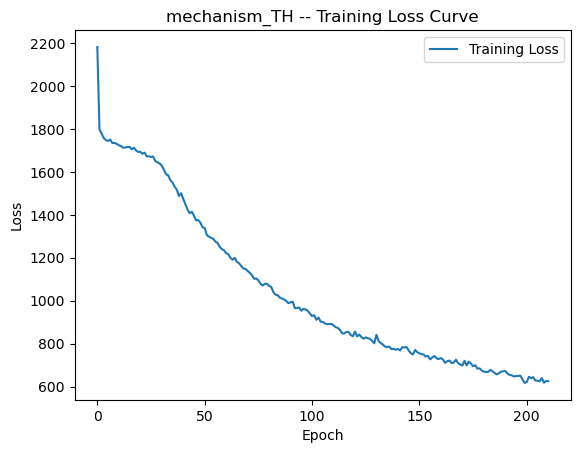

===== Checking mechanism: TAS =====
Iteration 1, loss = 26432.37963574
Iteration 2, loss = 13727.56443892
Iteration 3, loss = 13256.92535178
Iteration 4, loss = 13087.75745238
Iteration 5, loss = 12914.00023852
Iteration 6, loss = 12815.77142976
Iteration 7, loss = 12820.60659693
Iteration 8, loss = 12718.90083070
Iteration 9, loss = 12692.74416005
Iteration 10, loss = 12641.69982111
Iteration 11, loss = 12605.96491336
Iteration 12, loss = 12565.20427542
Iteration 13, loss = 12548.51512208
Iteration 14, loss = 12539.74538683
Iteration 15, loss = 12490.51571581
Iteration 16, loss = 12525.08730469
Iteration 17, loss = 12584.16525016
Iteration 18, loss = 12488.12261009
Iteration 19, loss = 12496.77829187
Iteration 20, loss = 12425.97023367
Iteration 21, loss = 12416.97785349
Iteration 22, loss = 12431.06500585
Iteration 23, loss = 12392.68394101
Iteration 24, loss = 12418.47185917
Iteration 25, loss = 12410.80636579
Iteration 26, loss = 12430.72265409
Iteration 27, loss = 12424.97494197
I

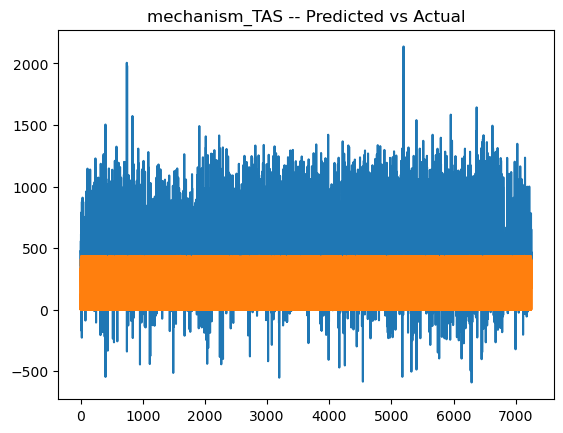

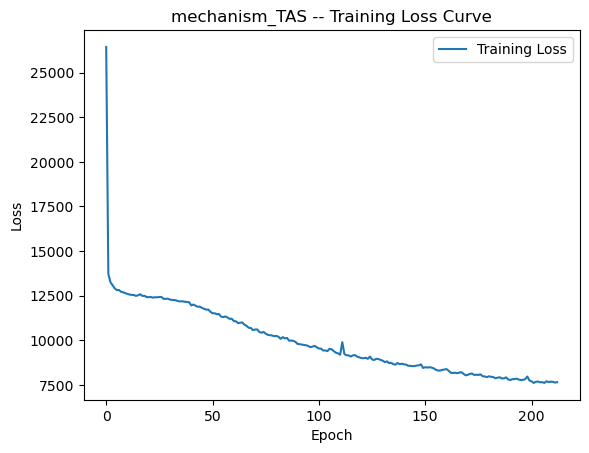

===== Checking mechanism: CASM =====
Iteration 1, loss = 13410.27524406
Iteration 2, loss = 605.50927833
Iteration 3, loss = 297.62959808
Iteration 4, loss = 179.14612822
Iteration 5, loss = 119.78245820
Iteration 6, loss = 88.47174788
Iteration 7, loss = 65.43371334
Iteration 8, loss = 51.66876815
Iteration 9, loss = 42.64288073
Iteration 10, loss = 34.75745227
Iteration 11, loss = 29.34946091
Iteration 12, loss = 24.89883412
Iteration 13, loss = 21.36650768
Iteration 14, loss = 18.46007249
Iteration 15, loss = 15.76112365
Iteration 16, loss = 13.61090732
Iteration 17, loss = 13.06878626
Iteration 18, loss = 11.57799027
Iteration 19, loss = 10.34138976
Iteration 20, loss = 9.41221466
Iteration 21, loss = 9.18974868
Iteration 22, loss = 7.36415597
Iteration 23, loss = 6.48167172
Iteration 24, loss = 5.77464270
Iteration 25, loss = 5.82831418
Iteration 26, loss = 5.66343884
Iteration 27, loss = 5.83295615
Iteration 28, loss = 4.12688473
Iteration 29, loss = 4.16292452
Iteration 30, loss

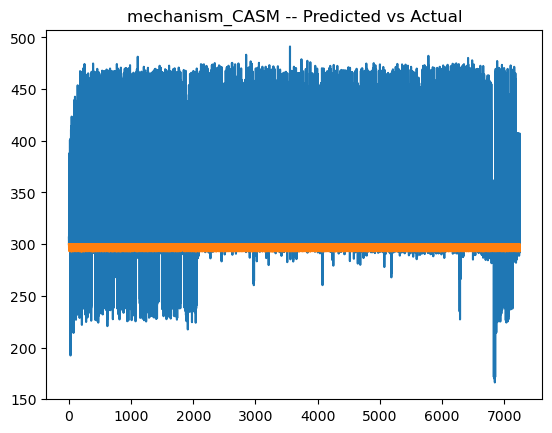

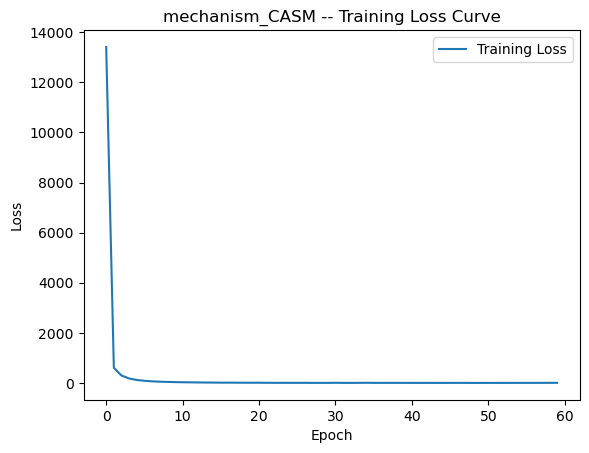

===== Checking mechanism: GS =====
Iteration 1, loss = 26056.51604743
Iteration 2, loss = 13420.94050596
Iteration 3, loss = 13039.54104024
Iteration 4, loss = 12887.59448863
Iteration 5, loss = 12788.07986215
Iteration 6, loss = 12679.50794904
Iteration 7, loss = 12617.54882880
Iteration 8, loss = 12581.89983566
Iteration 9, loss = 12542.35943019
Iteration 10, loss = 12466.63124698
Iteration 11, loss = 12477.41230658
Iteration 12, loss = 12446.10396389
Iteration 13, loss = 12406.63686136
Iteration 14, loss = 12397.13524866
Iteration 15, loss = 12385.88408247
Iteration 16, loss = 12370.94316473
Iteration 17, loss = 12377.86285266
Iteration 18, loss = 12328.76303940
Iteration 19, loss = 12345.74083900
Iteration 20, loss = 12286.55649869
Iteration 21, loss = 12313.46833285
Iteration 22, loss = 12226.91509311
Iteration 23, loss = 12276.62686039
Iteration 24, loss = 12243.59892611
Iteration 25, loss = 12266.30409537
Iteration 26, loss = 12210.21691306
Iteration 27, loss = 12183.61541272
It

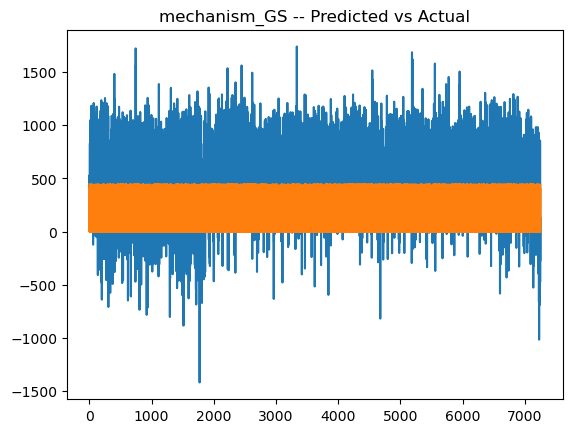

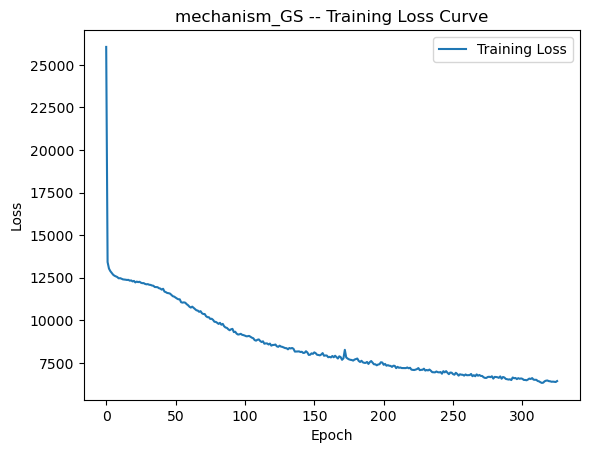

===== Checking mechanism: FPAC =====
Iteration 1, loss = 0.03889787
Iteration 2, loss = 0.00324394
Iteration 3, loss = 0.00115390
Iteration 4, loss = 0.00070222
Iteration 5, loss = 0.00058287
Iteration 6, loss = 0.00052178
Iteration 7, loss = 0.00048429
Iteration 8, loss = 0.00045715
Iteration 9, loss = 0.00043934
Iteration 10, loss = 0.00042664
Iteration 11, loss = 0.00041551
Iteration 12, loss = 0.00040838
Iteration 13, loss = 0.00040186
Iteration 14, loss = 0.00039549
Iteration 15, loss = 0.00039199
Iteration 16, loss = 0.00038703
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -0.8200517228151767


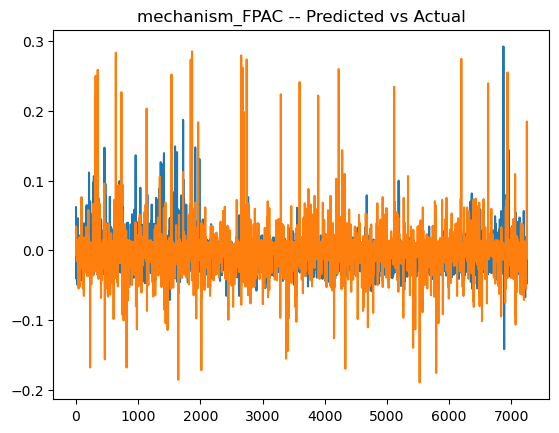

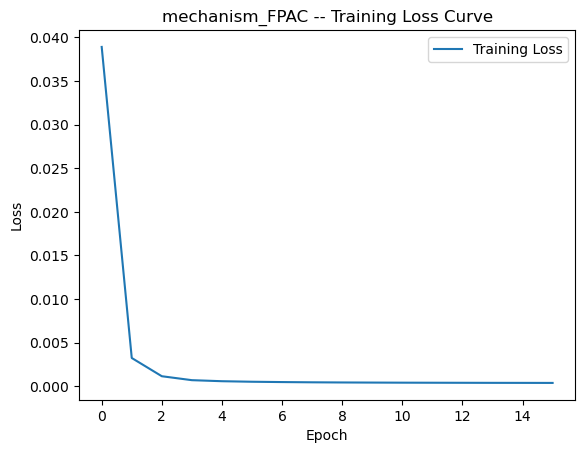

===== Checking mechanism: CTAC =====
Iteration 1, loss = 0.04212926
Iteration 2, loss = 0.00623147
Iteration 3, loss = 0.00443305
Iteration 4, loss = 0.00395469
Iteration 5, loss = 0.00380387
Iteration 6, loss = 0.00370917
Iteration 7, loss = 0.00364113
Iteration 8, loss = 0.00359455
Iteration 9, loss = 0.00356132
Iteration 10, loss = 0.00352843
Iteration 11, loss = 0.00349221
Iteration 12, loss = 0.00346894
Iteration 13, loss = 0.00344642
Iteration 14, loss = 0.00342754
Iteration 15, loss = 0.00340213
Iteration 16, loss = 0.00337707
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -0.45634241241593254


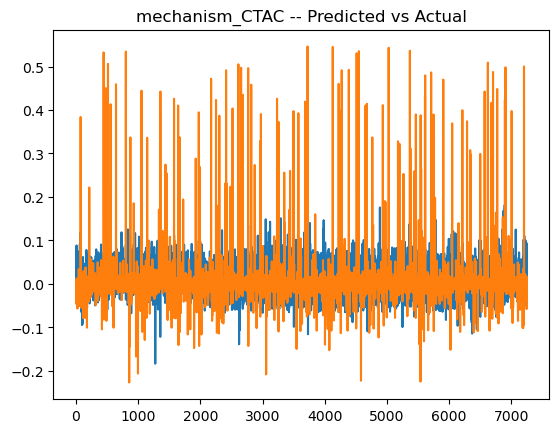

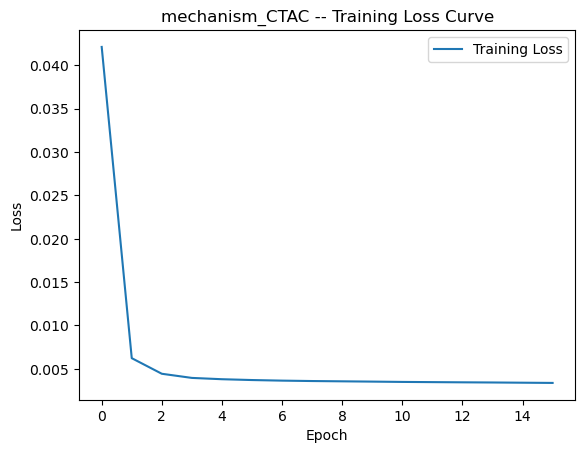

===== Checking power: FADS =====
Iteration 1, loss = 11.12650538
Iteration 2, loss = 0.81984184
Iteration 3, loss = 0.36094263
Iteration 4, loss = 0.21362479
Iteration 5, loss = 0.14015875
Iteration 6, loss = 0.10000334
Iteration 7, loss = 0.07989078
Iteration 8, loss = 0.06902574
Iteration 9, loss = 0.04858028
Iteration 10, loss = 0.04757895
Iteration 11, loss = 0.04267893
Iteration 12, loss = 0.03559950
Iteration 13, loss = 0.02967149
Iteration 14, loss = 0.02750905
Iteration 15, loss = 0.02801716
Iteration 16, loss = 0.02205477
Iteration 17, loss = 0.01985163
Iteration 18, loss = 0.01906073
Iteration 19, loss = 0.01887712
Iteration 20, loss = 0.01575828
Iteration 21, loss = 0.01980235
Iteration 22, loss = 0.01893651
Iteration 23, loss = 0.01920791
Iteration 24, loss = 0.01679962
Iteration 25, loss = 0.01764092
Iteration 26, loss = 0.01662880
Iteration 27, loss = 0.02215129
Iteration 28, loss = 0.01784427
Iteration 29, loss = 0.01571820
Iteration 30, loss = 0.02391903
Iteration 31, l

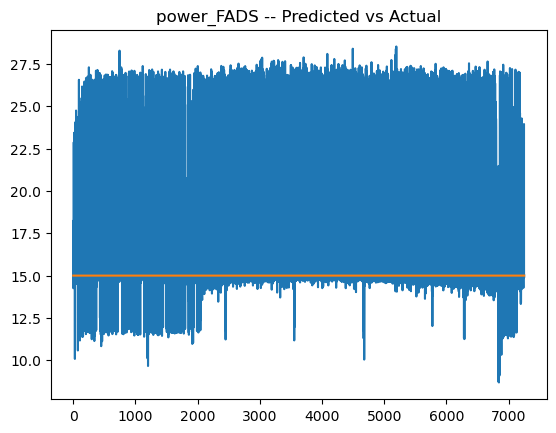

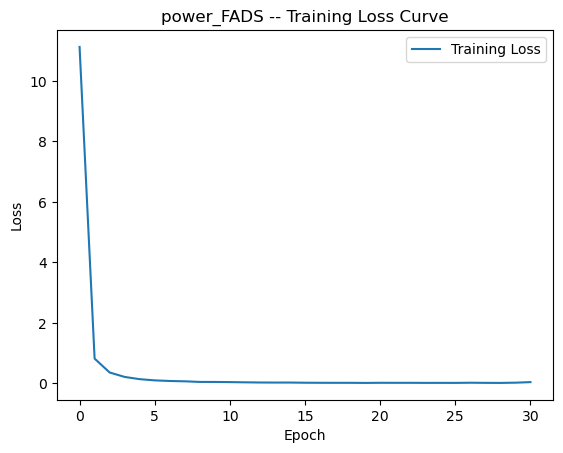

===== Checking power: FQTY_1 =====
Iteration 1, loss = 17173817.63902187
Iteration 2, loss = 1553802.83486773
Iteration 3, loss = 524968.82938598
Iteration 4, loss = 308178.26258827
Iteration 5, loss = 212152.04167774
Iteration 6, loss = 157688.48989513
Iteration 7, loss = 119480.46200175
Iteration 8, loss = 91931.74628809
Iteration 9, loss = 71850.26248230
Iteration 10, loss = 56920.82567438
Iteration 11, loss = 46460.22069964
Iteration 12, loss = 38503.26055519
Iteration 13, loss = 32730.03487332
Iteration 14, loss = 28364.85185014
Iteration 15, loss = 24949.93288237
Iteration 16, loss = 22238.61659291
Iteration 17, loss = 20248.50250961
Iteration 18, loss = 18444.76010703
Iteration 19, loss = 16838.43153813
Iteration 20, loss = 15846.54579947
Iteration 21, loss = 14669.33119397
Iteration 22, loss = 13721.76580351
Iteration 23, loss = 12808.85609799
Iteration 24, loss = 12200.35074907
Iteration 25, loss = 11489.62243654
Iteration 26, loss = 10890.45811767
Iteration 27, loss = 10453.7

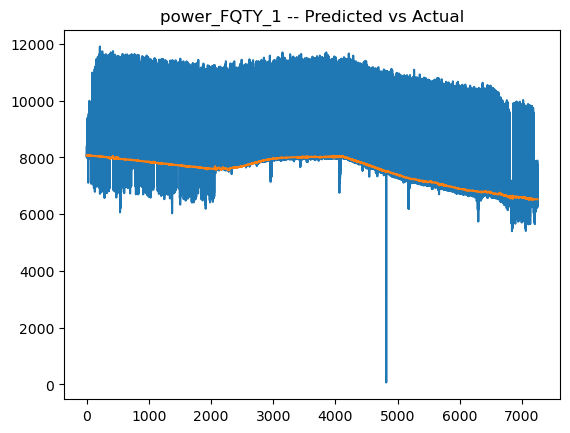

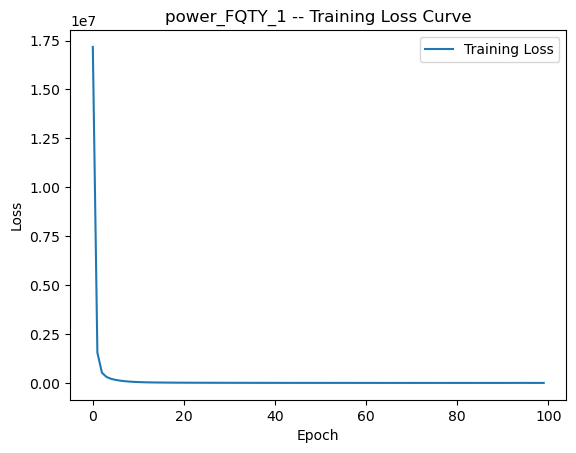

===== Checking power: FQTY_2 =====
Iteration 1, loss = 450433.61091926
Iteration 2, loss = 243889.47056498
Iteration 3, loss = 193394.82284878
Iteration 4, loss = 151374.20629578
Iteration 5, loss = 113634.89969262
Iteration 6, loss = 88378.52187463
Iteration 7, loss = 68032.31941065
Iteration 8, loss = 56873.25034734
Iteration 9, loss = 46486.01370254
Iteration 10, loss = 40572.38185937
Iteration 11, loss = 35997.06077968
Iteration 12, loss = 33068.88281482
Iteration 13, loss = 28924.11220320
Iteration 14, loss = 25631.42777867
Iteration 15, loss = 23206.68964274
Iteration 16, loss = 20775.21643854
Iteration 17, loss = 17702.53152297
Iteration 18, loss = 17093.27072971
Iteration 19, loss = 14901.63628086
Iteration 20, loss = 11807.32306564
Iteration 21, loss = 11173.57054857
Iteration 22, loss = 10671.63831223
Iteration 23, loss = 9745.44459434
Iteration 24, loss = 8720.73403962
Iteration 25, loss = 9030.47110739
Iteration 26, loss = 8033.03624270
Iteration 27, loss = 8047.21377553
It

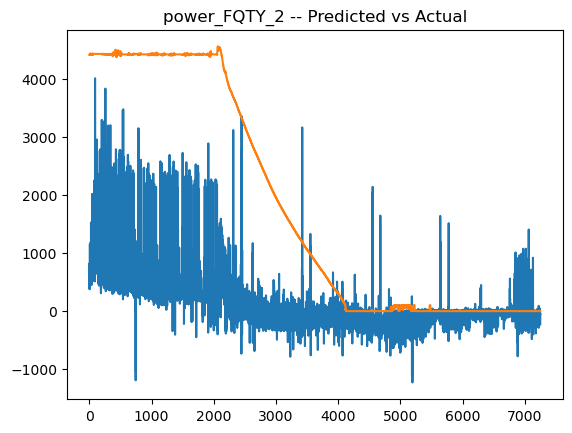

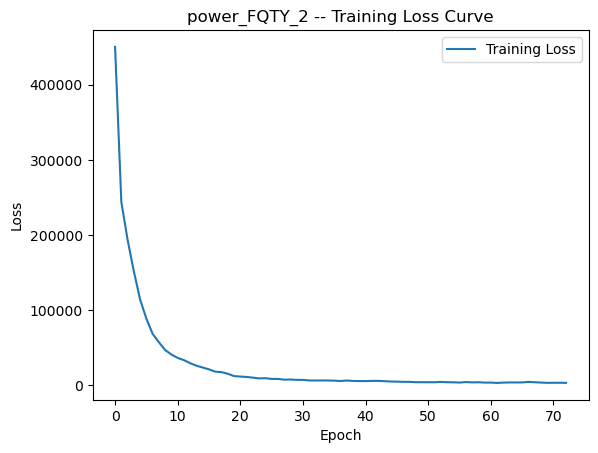

===== Checking power: FQTY_3 =====
Iteration 1, loss = 18169.71977267
Iteration 2, loss = 18169.95074207
Iteration 3, loss = 18171.49272413
Iteration 4, loss = 18169.71347262
Iteration 5, loss = 18173.10836243
Iteration 6, loss = 18170.39680018
Iteration 7, loss = 18169.63723617
Iteration 8, loss = 18169.63104766
Iteration 9, loss = 18170.41178978
Iteration 10, loss = 18169.31905133
Iteration 11, loss = 18177.65833542
Iteration 12, loss = 18203.20275559
Iteration 13, loss = 18167.65935767
Iteration 14, loss = 18184.03934028
Iteration 15, loss = 17990.29711927
Iteration 16, loss = 18190.89060665
Iteration 17, loss = 18163.74538099
Iteration 18, loss = 17897.66015874
Iteration 19, loss = 18168.72024828
Iteration 20, loss = 17847.39588239
Iteration 21, loss = 17713.97966743
Iteration 22, loss = 17562.00263371
Iteration 23, loss = 17248.92401198
Iteration 24, loss = 17293.63002048
Iteration 25, loss = 17017.98348776
Iteration 26, loss = 16777.12267576
Iteration 27, loss = 16038.32393773
It

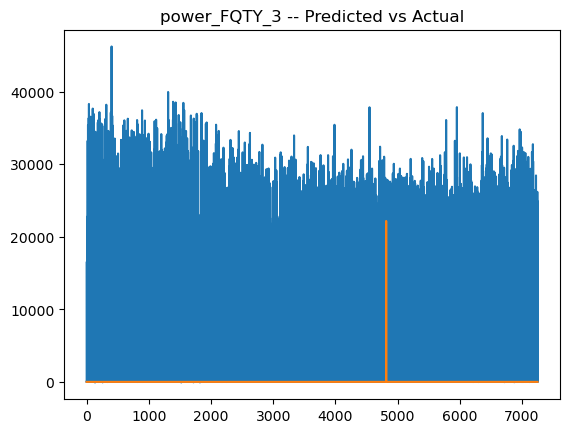

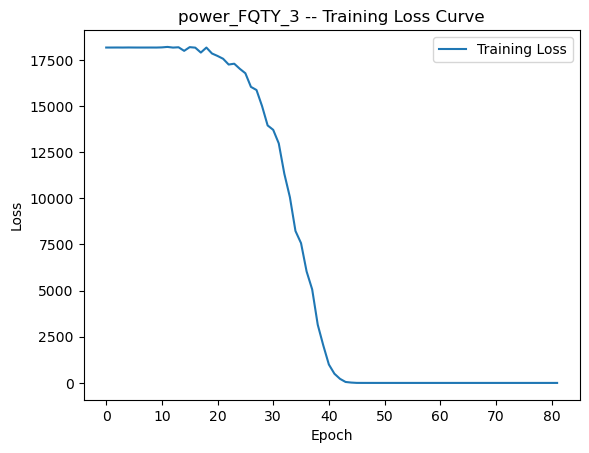

===== Checking power: FQTY_4 =====
Iteration 1, loss = 16932470.99659704
Iteration 2, loss = 1556030.67013779
Iteration 3, loss = 515789.79672597
Iteration 4, loss = 304451.48711975
Iteration 5, loss = 210736.70293882
Iteration 6, loss = 157198.90582223
Iteration 7, loss = 119655.99157631
Iteration 8, loss = 92731.61050806
Iteration 9, loss = 73107.24396871
Iteration 10, loss = 58389.57223959
Iteration 11, loss = 47866.71498205
Iteration 12, loss = 40054.55062865
Iteration 13, loss = 34090.90719696
Iteration 14, loss = 29622.84547668
Iteration 15, loss = 26111.36254043
Iteration 16, loss = 23333.98232374
Iteration 17, loss = 21348.44642288
Iteration 18, loss = 19484.24699144
Iteration 19, loss = 17831.88797597
Iteration 20, loss = 16824.16128875
Iteration 21, loss = 15613.63522910
Iteration 22, loss = 14608.50092971
Iteration 23, loss = 13683.39924515
Iteration 24, loss = 13066.30953248
Iteration 25, loss = 12285.48266699
Iteration 26, loss = 11600.62760284
Iteration 27, loss = 11217.6

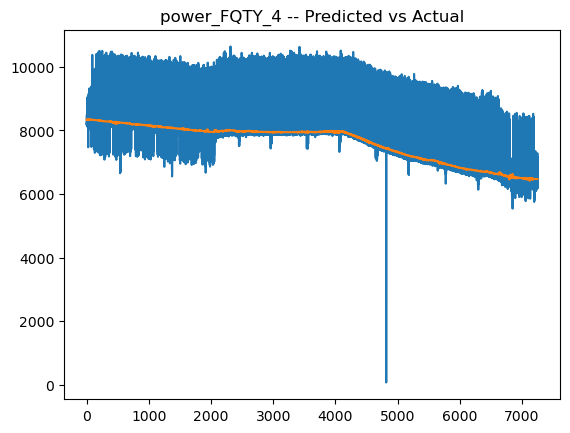

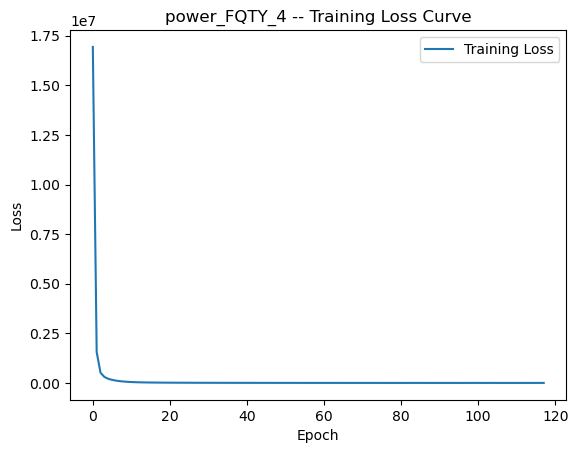

===== Checking power: OIPL =====
Iteration 1, loss = 10.93029753
Iteration 2, loss = 0.72136424
Iteration 3, loss = 0.33355298
Iteration 4, loss = 0.21393736
Iteration 5, loss = 0.14869756
Iteration 6, loss = 0.11137106
Iteration 7, loss = 0.09556180
Iteration 8, loss = 0.07534818
Iteration 9, loss = 0.06840477
Iteration 10, loss = 0.06510908
Iteration 11, loss = 0.05418941
Iteration 12, loss = 0.05295474
Iteration 13, loss = 0.04536432
Iteration 14, loss = 0.04658555
Iteration 15, loss = 0.04169288
Iteration 16, loss = 0.03450987
Iteration 17, loss = 0.03113147
Iteration 18, loss = 0.03182783
Iteration 19, loss = 0.03599171
Iteration 20, loss = 0.04422294
Iteration 21, loss = 0.04471970
Iteration 22, loss = 0.04118209
Iteration 23, loss = 0.03338482
Iteration 24, loss = 0.03310204
Iteration 25, loss = 0.03801440
Iteration 26, loss = 0.03641553
Iteration 27, loss = 0.03238402
Iteration 28, loss = 0.02834212
Iteration 29, loss = 0.02526706
Iteration 30, loss = 0.02627364
Iteration 31, l

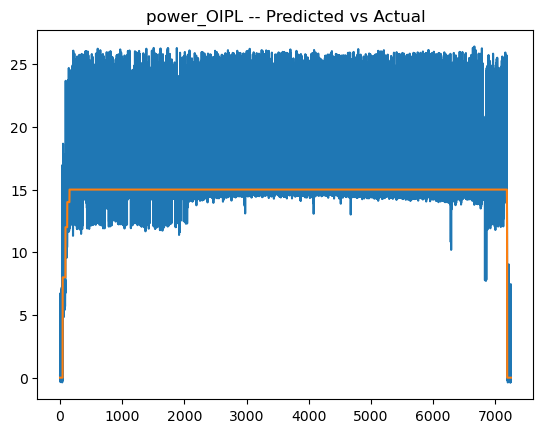

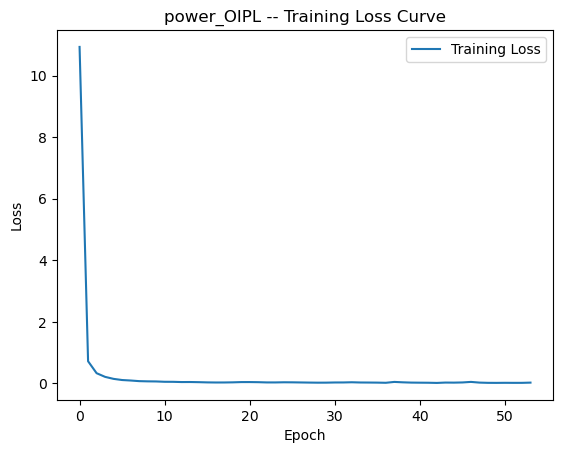

===== Checking power: LGDN =====
Iteration 1, loss = 0.07216877
Iteration 2, loss = 0.01325330
Iteration 3, loss = 0.03003131
Iteration 4, loss = 0.00184804
Iteration 5, loss = 0.00135909
Iteration 6, loss = 0.00080419
Iteration 7, loss = 0.00066437
Iteration 8, loss = 0.00055829
Iteration 9, loss = 0.00051927
Iteration 10, loss = 0.00045809
Iteration 11, loss = 0.00041266
Iteration 12, loss = 0.00039012
Iteration 13, loss = 0.00036998
Iteration 14, loss = 0.00037759
Iteration 15, loss = 0.00034061
Iteration 16, loss = 0.00031797
Iteration 17, loss = 0.00031260
Iteration 18, loss = 0.00031201
Iteration 19, loss = 0.00028834
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： 0.8206872827070133


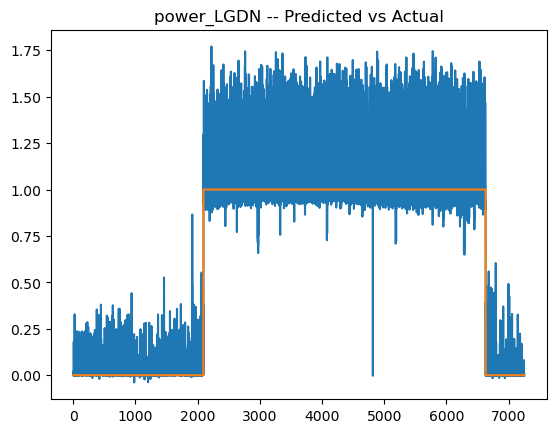

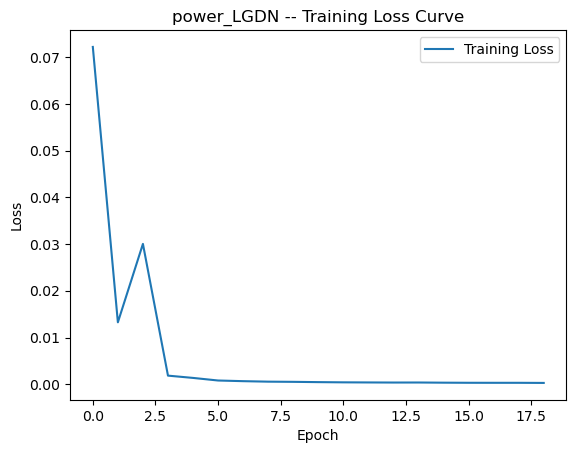

===== Checking control: HDGS =====
Iteration 1, loss = 1892.49379982
Iteration 2, loss = 608.52702632
Iteration 3, loss = 442.59410058
Iteration 4, loss = 340.25287364
Iteration 5, loss = 269.73703075
Iteration 6, loss = 222.47701025
Iteration 7, loss = 182.53200298
Iteration 8, loss = 164.94921946
Iteration 9, loss = 147.40200123
Iteration 10, loss = 139.48819761
Iteration 11, loss = 131.76833406
Iteration 12, loss = 116.69821260
Iteration 13, loss = 108.59411482
Iteration 14, loss = 102.93549941
Iteration 15, loss = 94.56478238
Iteration 16, loss = 84.42710212
Iteration 17, loss = 79.04394595
Iteration 18, loss = 69.69856283
Iteration 19, loss = 64.45383392
Iteration 20, loss = 58.67383558
Iteration 21, loss = 60.15373913
Iteration 22, loss = 53.36135346
Iteration 23, loss = 50.43901424
Iteration 24, loss = 43.24933544
Iteration 25, loss = 44.10410915
Iteration 26, loss = 39.91656139
Iteration 27, loss = 37.20202666
Iteration 28, loss = 34.48297234
Iteration 29, loss = 32.89005791
It

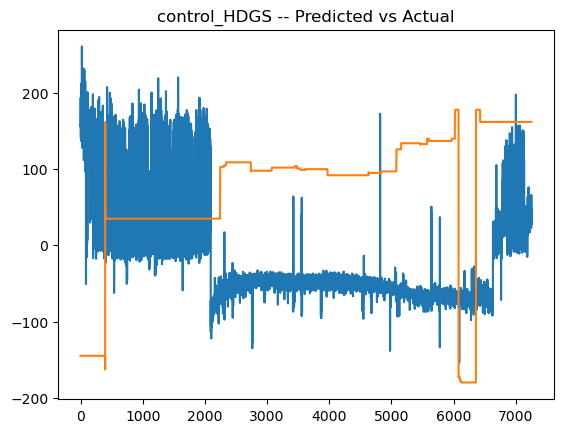

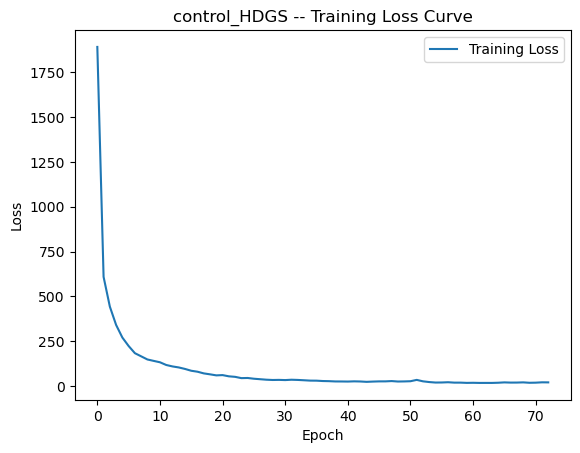

===== Checking control: RUDP =====
Iteration 1, loss = 1157969.39764141
Iteration 2, loss = 81795.32055961
Iteration 3, loss = 43226.99914003
Iteration 4, loss = 31727.49282614
Iteration 5, loss = 25695.62089136
Iteration 6, loss = 22287.10043634
Iteration 7, loss = 19963.25746023
Iteration 8, loss = 18523.56129174
Iteration 9, loss = 17472.11214615
Iteration 10, loss = 16714.33889494
Iteration 11, loss = 16156.92785744
Iteration 12, loss = 15758.31269142
Iteration 13, loss = 15523.81787561
Iteration 14, loss = 15288.48999800
Iteration 15, loss = 15160.19002043
Iteration 16, loss = 14865.36388316
Iteration 17, loss = 14852.14697804
Iteration 18, loss = 14538.24281298
Iteration 19, loss = 14580.72387874
Iteration 20, loss = 14500.13078875
Iteration 21, loss = 14220.80653212
Iteration 22, loss = 14221.22997888
Iteration 23, loss = 14042.32843002
Iteration 24, loss = 14195.27325222
Iteration 25, loss = 13957.51583916
Iteration 26, loss = 13910.43336823
Iteration 27, loss = 13923.79082391


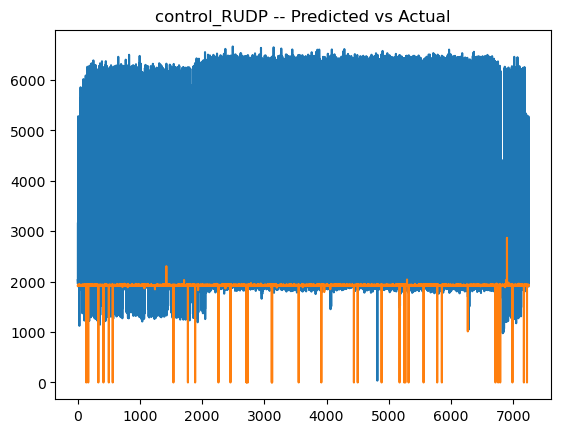

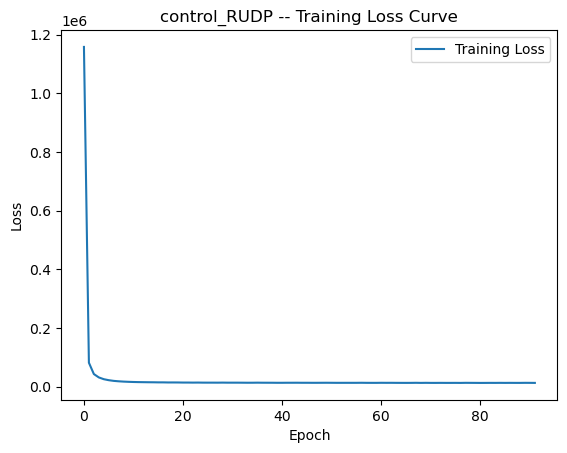

===== Checking control: CCPC =====
Iteration 1, loss = 2313489.22158741
Iteration 2, loss = 250485.22277393
Iteration 3, loss = 164983.05931520
Iteration 4, loss = 141727.50151567
Iteration 5, loss = 128931.14539518
Iteration 6, loss = 121612.30013763
Iteration 7, loss = 116043.27572823
Iteration 8, loss = 111063.35511141
Iteration 9, loss = 108749.18831560
Iteration 10, loss = 106203.69926236
Iteration 11, loss = 104981.75885063
Iteration 12, loss = 103530.92605327
Iteration 13, loss = 102814.67064700
Iteration 14, loss = 101591.61548949
Iteration 15, loss = 101097.76132321
Iteration 16, loss = 100486.08302056
Iteration 17, loss = 99671.47216783
Iteration 18, loss = 99376.47811601
Iteration 19, loss = 98643.00287601
Iteration 20, loss = 99674.78525738
Iteration 21, loss = 98269.12549369
Iteration 22, loss = 98424.07327254
Iteration 23, loss = 98004.00381815
Iteration 24, loss = 98322.08064137
Iteration 25, loss = 97729.80831820
Iteration 26, loss = 97211.19787872
Iteration 27, loss = 

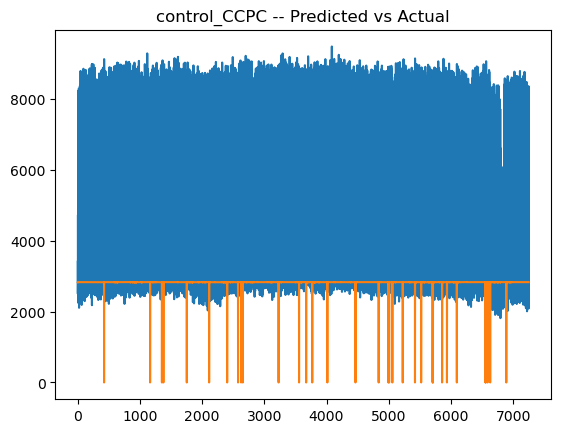

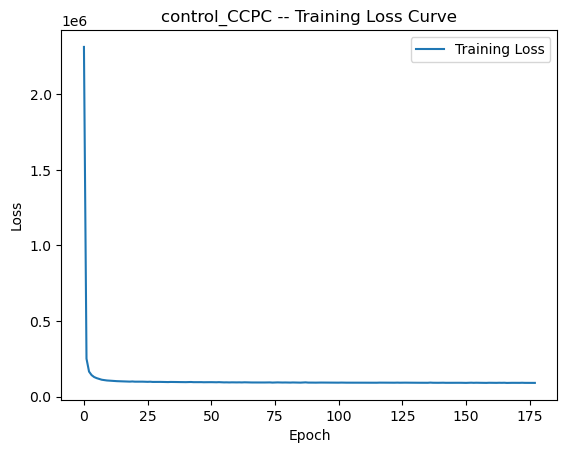

===== Checking control: CCPF =====
Iteration 1, loss = 1322480.68083032
Iteration 2, loss = 90351.89969082
Iteration 3, loss = 46620.57355464
Iteration 4, loss = 33995.95390486
Iteration 5, loss = 27402.56676817
Iteration 6, loss = 23388.79933214
Iteration 7, loss = 20736.33537131
Iteration 8, loss = 19052.96411678
Iteration 9, loss = 17808.70797705
Iteration 10, loss = 17030.30827668
Iteration 11, loss = 16422.06923032
Iteration 12, loss = 15983.11991849
Iteration 13, loss = 15574.96315520
Iteration 14, loss = 15351.85549556
Iteration 15, loss = 15027.37832545
Iteration 16, loss = 14849.12387782
Iteration 17, loss = 14732.04160044
Iteration 18, loss = 14480.99129166
Iteration 19, loss = 14497.66453881
Iteration 20, loss = 14360.99624958
Iteration 21, loss = 14275.85468545
Iteration 22, loss = 14152.91981386
Iteration 23, loss = 14127.49105876
Iteration 24, loss = 14117.87098766
Iteration 25, loss = 14052.79549015
Iteration 26, loss = 14064.97945323
Iteration 27, loss = 13752.09618046


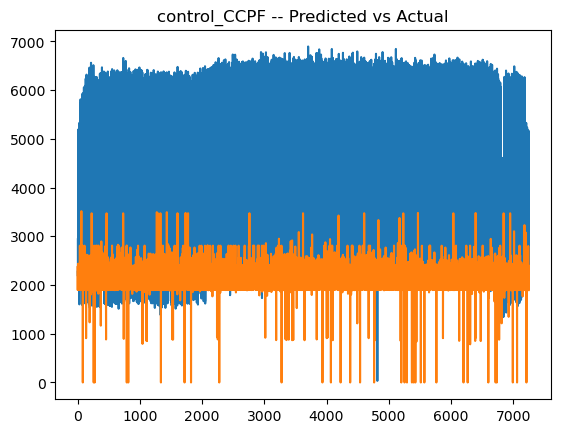

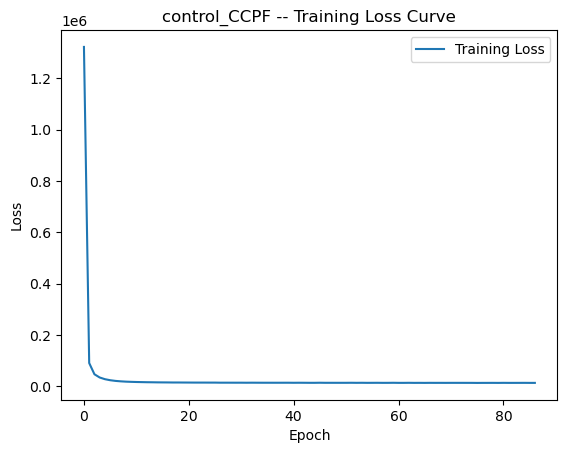

===== Checking control: CWPC =====
Iteration 1, loss = 1397672.75911725
Iteration 2, loss = 103788.41982649
Iteration 3, loss = 55482.73393659
Iteration 4, loss = 41202.38783522
Iteration 5, loss = 33899.41716468
Iteration 6, loss = 29492.52172242
Iteration 7, loss = 26660.99660006
Iteration 8, loss = 24667.35105242
Iteration 9, loss = 23430.83520433
Iteration 10, loss = 22464.34446515
Iteration 11, loss = 21996.59403927
Iteration 12, loss = 21342.23138064
Iteration 13, loss = 21095.14627467
Iteration 14, loss = 20806.30306160
Iteration 15, loss = 20413.23677386
Iteration 16, loss = 20214.96134112
Iteration 17, loss = 20128.37195558
Iteration 18, loss = 20122.55887826
Iteration 19, loss = 19798.57150864
Iteration 20, loss = 19689.05243877
Iteration 21, loss = 19522.77429809
Iteration 22, loss = 19615.11329517
Iteration 23, loss = 19390.45736411
Iteration 24, loss = 19299.92523685
Iteration 25, loss = 19251.26089277
Iteration 26, loss = 19311.74248421
Iteration 27, loss = 19269.74919112

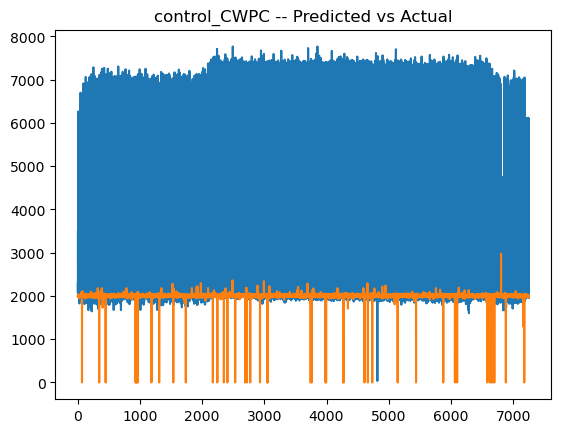

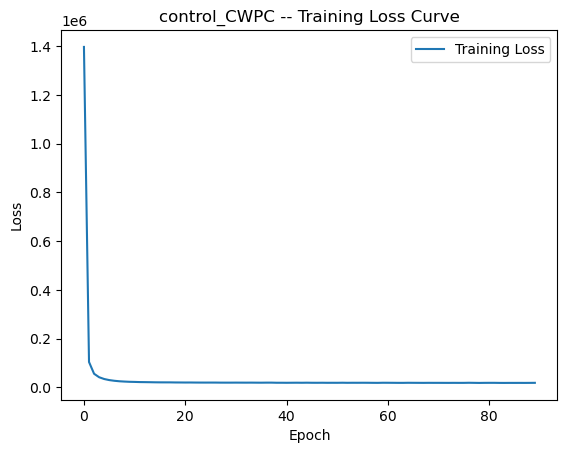

===== Checking control: CWPF =====
Iteration 1, loss = 1067068.89264222
Iteration 2, loss = 72328.95613510
Iteration 3, loss = 37549.56217032
Iteration 4, loss = 27000.65842116
Iteration 5, loss = 21556.49133106
Iteration 6, loss = 18266.16576681
Iteration 7, loss = 15996.00448694
Iteration 8, loss = 14665.61380260
Iteration 9, loss = 13752.89745710
Iteration 10, loss = 13003.82405039
Iteration 11, loss = 12472.03241903
Iteration 12, loss = 12030.55811476
Iteration 13, loss = 11749.61989548
Iteration 14, loss = 11553.56295048
Iteration 15, loss = 11271.45021377
Iteration 16, loss = 11085.08032300
Iteration 17, loss = 10959.39883758
Iteration 18, loss = 10876.82286134
Iteration 19, loss = 10741.85399372
Iteration 20, loss = 10669.63208454
Iteration 21, loss = 10599.15091152
Iteration 22, loss = 10630.70650588
Iteration 23, loss = 10540.68444593
Iteration 24, loss = 10515.18952515
Iteration 25, loss = 10314.99458254
Iteration 26, loss = 10357.28336501
Iteration 27, loss = 10271.39669770


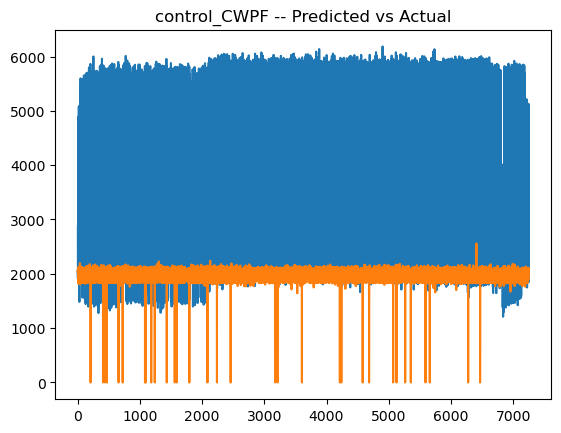

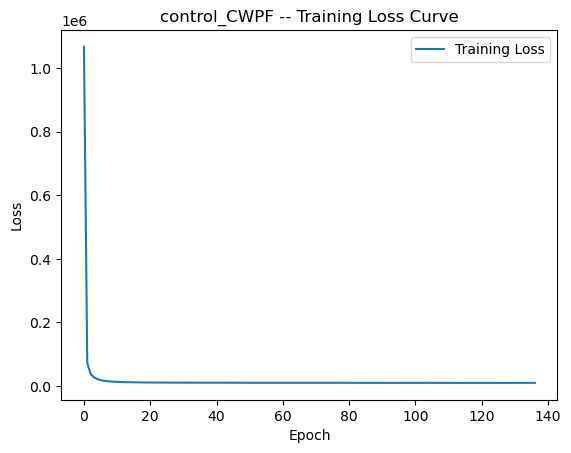

===== Checking control: SNAP =====
Iteration 1, loss = 0.07924755
Iteration 2, loss = 0.02072579
Iteration 3, loss = 0.02226102
Iteration 4, loss = 0.00187222
Iteration 5, loss = 0.00150476
Iteration 6, loss = 0.00113517
Iteration 7, loss = 0.00076520
Iteration 8, loss = 0.00059159
Iteration 9, loss = 0.00049955
Iteration 10, loss = 0.00042476
Iteration 11, loss = 0.00037329
Iteration 12, loss = 0.00034272
Iteration 13, loss = 0.00029686
Iteration 14, loss = 0.00026366
Iteration 15, loss = 0.00024903
Iteration 16, loss = 0.00022762
Iteration 17, loss = 0.00021730
Iteration 18, loss = 0.00019808
Iteration 19, loss = 0.00017461
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： 0.0


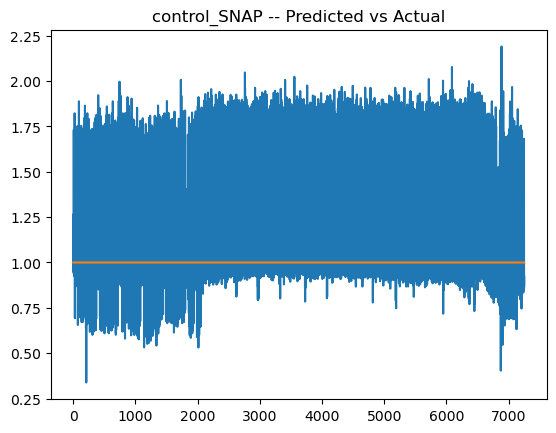

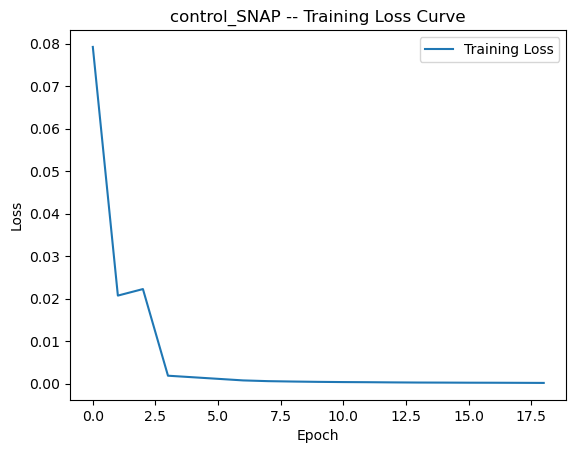

===== Checking control: SHKR =====
Iteration 1, loss = 0.18301679
Iteration 2, loss = 0.12886216
Iteration 3, loss = 0.13221821
Iteration 4, loss = 0.12666044
Iteration 5, loss = 0.12265674
Iteration 6, loss = 0.12018813
Iteration 7, loss = 0.11882143
Iteration 8, loss = 0.11682746
Iteration 9, loss = 0.11638361
Iteration 10, loss = 0.11506061
Iteration 11, loss = 0.11418472
Iteration 12, loss = 0.11232440
Iteration 13, loss = 0.11190468
Iteration 14, loss = 0.11055444
Iteration 15, loss = 0.10877775
Iteration 16, loss = 0.10759391
Iteration 17, loss = 0.10611612
Iteration 18, loss = 0.10575755
Iteration 19, loss = 0.10409458
Iteration 20, loss = 0.10332614
Iteration 21, loss = 0.10126128
Iteration 22, loss = 0.12319574
Iteration 23, loss = 0.10158528
Iteration 24, loss = 0.10073351
Iteration 25, loss = 0.09977662
Iteration 26, loss = 0.09744938
Iteration 27, loss = 0.09496421
Iteration 28, loss = 0.09489368
Iteration 29, loss = 0.09349256
Iteration 30, loss = 0.09239916
Iteration 31, 

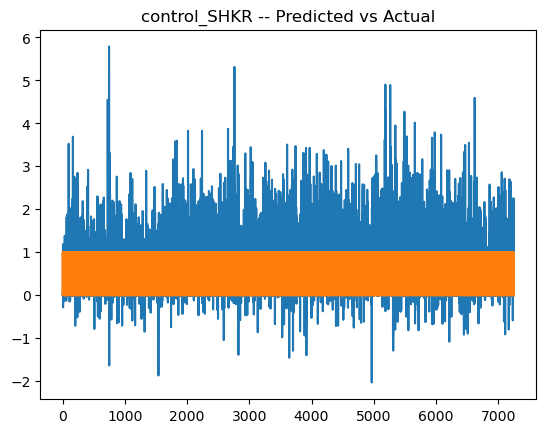

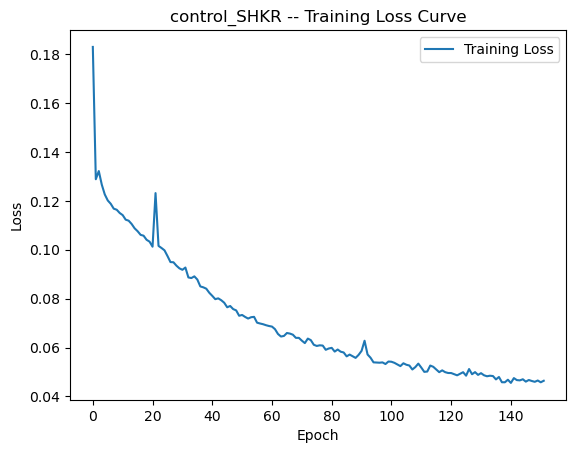

===== Checking control: FADF =====
Iteration 1, loss = 11.12650538
Iteration 2, loss = 0.81984184
Iteration 3, loss = 0.36094263
Iteration 4, loss = 0.21362479
Iteration 5, loss = 0.14015875
Iteration 6, loss = 0.10000334
Iteration 7, loss = 0.07989078
Iteration 8, loss = 0.06902574
Iteration 9, loss = 0.04858028
Iteration 10, loss = 0.04757895
Iteration 11, loss = 0.04267893
Iteration 12, loss = 0.03559950
Iteration 13, loss = 0.02967149
Iteration 14, loss = 0.02750905
Iteration 15, loss = 0.02801716
Iteration 16, loss = 0.02205477
Iteration 17, loss = 0.01985163
Iteration 18, loss = 0.01906073
Iteration 19, loss = 0.01887712
Iteration 20, loss = 0.01575828
Iteration 21, loss = 0.01980235
Iteration 22, loss = 0.01893651
Iteration 23, loss = 0.01920791
Iteration 24, loss = 0.01679962
Iteration 25, loss = 0.01764092
Iteration 26, loss = 0.01662880
Iteration 27, loss = 0.02215129
Iteration 28, loss = 0.01784427
Iteration 29, loss = 0.01571820
Iteration 30, loss = 0.02391903
Iteration 31,

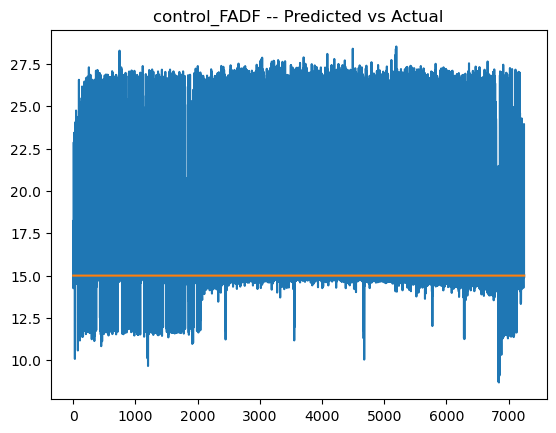

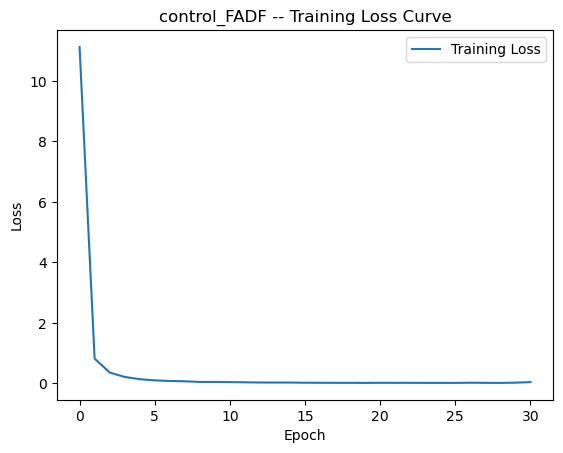

===== Checking external: ALT =====
Iteration 1, loss = 158239735.49956176
Iteration 2, loss = 67282269.57985376
Iteration 3, loss = 55274654.56120011
Iteration 4, loss = 53358461.89542194
Iteration 5, loss = 52270191.83244509
Iteration 6, loss = 51593283.53089690
Iteration 7, loss = 51088059.65031275
Iteration 8, loss = 50705099.93748758
Iteration 9, loss = 50402697.23790954
Iteration 10, loss = 50230309.69181062
Iteration 11, loss = 50037536.45111457
Iteration 12, loss = 49868439.67991780
Iteration 13, loss = 49758431.90591498
Iteration 14, loss = 49626878.64240193
Iteration 15, loss = 49562421.23400667
Iteration 16, loss = 49417674.38426161
Iteration 17, loss = 49354406.03861418
Iteration 18, loss = 49255424.69720716
Iteration 19, loss = 49194055.40821904
Iteration 20, loss = 49108627.41716497
Iteration 21, loss = 49066286.01782873
Iteration 22, loss = 49001785.61265399
Iteration 23, loss = 49019813.60776099
Iteration 24, loss = 48908292.17561418
Iteration 25, loss = 48832159.0287362

d:\coding\Anaconda\Software\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


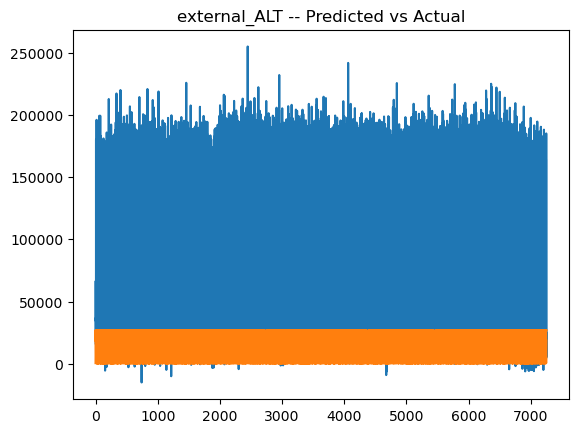

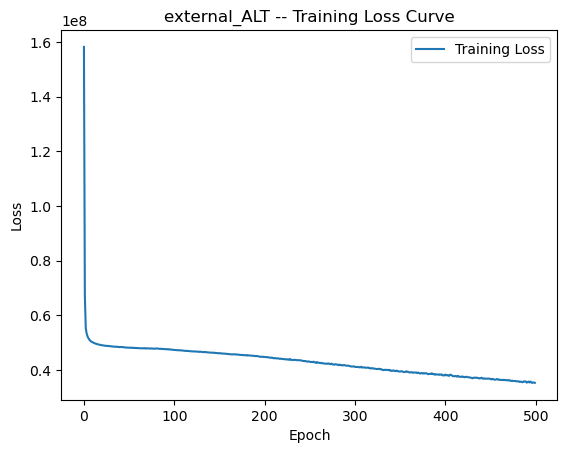

===== Checking external: WS =====
Iteration 1, loss = 250.54602852
Iteration 2, loss = 222.12915940
Iteration 3, loss = 219.33446443
Iteration 4, loss = 217.52632890
Iteration 5, loss = 216.42978007
Iteration 6, loss = 215.19498624
Iteration 7, loss = 215.83264916
Iteration 8, loss = 214.40462655
Iteration 9, loss = 214.55565809
Iteration 10, loss = 212.40890799
Iteration 11, loss = 211.33802666
Iteration 12, loss = 211.99427189
Iteration 13, loss = 210.04781484
Iteration 14, loss = 209.02415734
Iteration 15, loss = 207.05887736
Iteration 16, loss = 207.87169612
Iteration 17, loss = 206.44294945
Iteration 18, loss = 206.51352226
Iteration 19, loss = 204.00688666
Iteration 20, loss = 203.80931090
Iteration 21, loss = 203.12599924
Iteration 22, loss = 203.79303702
Iteration 23, loss = 201.95694035
Iteration 24, loss = 201.17045160
Iteration 25, loss = 199.58544216
Iteration 26, loss = 197.51147331
Iteration 27, loss = 197.26040293
Iteration 28, loss = 196.21854229
Iteration 29, loss = 19

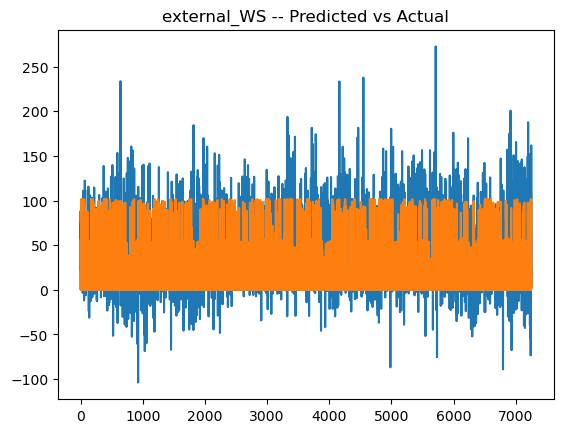

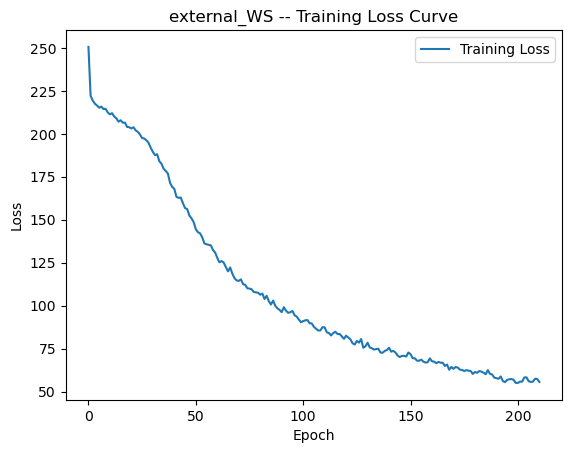

===== Checking external: WD =====
Iteration 1, loss = 4980.14508057
Iteration 2, loss = 4929.74052541
Iteration 3, loss = 4913.02696837
Iteration 4, loss = 4889.54008290
Iteration 5, loss = 4871.55085932
Iteration 6, loss = 4844.10305133
Iteration 7, loss = 4805.92427088
Iteration 8, loss = 4769.15165906
Iteration 9, loss = 4736.61051696
Iteration 10, loss = 4688.50289973
Iteration 11, loss = 4623.34828060
Iteration 12, loss = 4584.99911526
Iteration 13, loss = 4528.71720677
Iteration 14, loss = 4465.77973301
Iteration 15, loss = 4419.02729852
Iteration 16, loss = 4375.26340939
Iteration 17, loss = 4291.45397290
Iteration 18, loss = 4231.01650126
Iteration 19, loss = 4166.30501832
Iteration 20, loss = 4124.95290347
Iteration 21, loss = 4045.64879376
Iteration 22, loss = 3972.60564568
Iteration 23, loss = 3939.61039559
Iteration 24, loss = 3841.00644751
Iteration 25, loss = 3796.97863497
Iteration 26, loss = 3715.09029065
Iteration 27, loss = 3657.31441991
Iteration 28, loss = 3611.4920

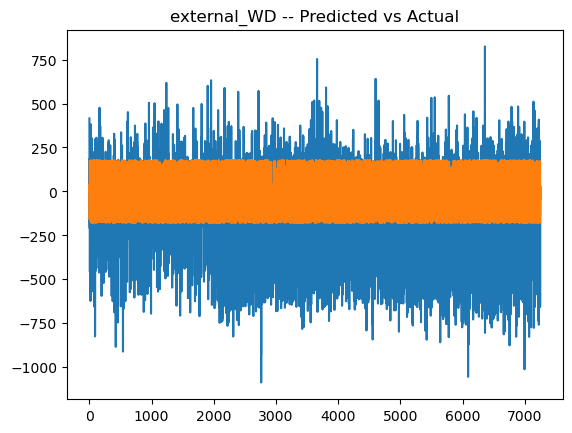

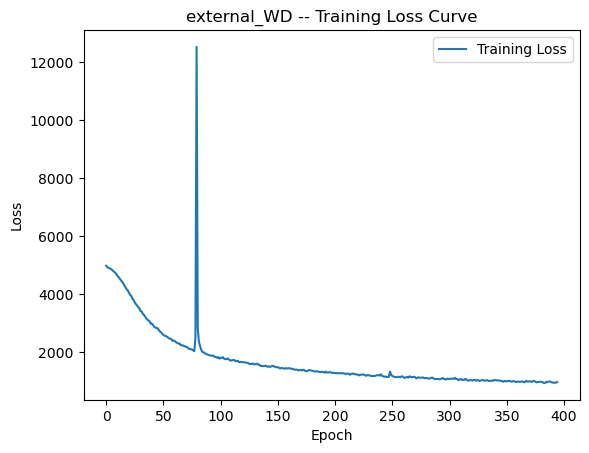

===== Checking external: PT =====
Iteration 1, loss = 117259.06355599
Iteration 2, loss = 24369.09508154
Iteration 3, loss = 21760.43940289
Iteration 4, loss = 20751.69723999
Iteration 5, loss = 20142.36589165
Iteration 6, loss = 19890.92494101
Iteration 7, loss = 19527.87687074
Iteration 8, loss = 19419.16166206
Iteration 9, loss = 19242.17584004
Iteration 10, loss = 19189.44897891
Iteration 11, loss = 19017.64420342
Iteration 12, loss = 18990.87196342
Iteration 13, loss = 18902.89942411
Iteration 14, loss = 18972.91909464
Iteration 15, loss = 18809.89815245
Iteration 16, loss = 18885.23845971
Iteration 17, loss = 18720.87269916
Iteration 18, loss = 18698.83435697
Iteration 19, loss = 18648.71914133
Iteration 20, loss = 18690.01424689
Iteration 21, loss = 18672.23553590
Iteration 22, loss = 18609.69641902
Iteration 23, loss = 18663.95525431
Iteration 24, loss = 18597.19218354
Iteration 25, loss = 18575.48096237
Iteration 26, loss = 18556.86740833
Iteration 27, loss = 18567.41353501
It

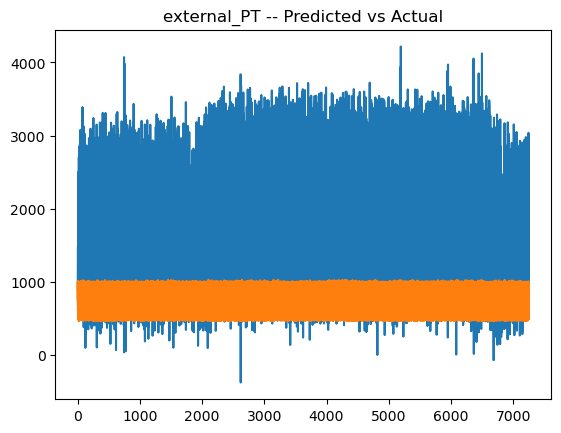

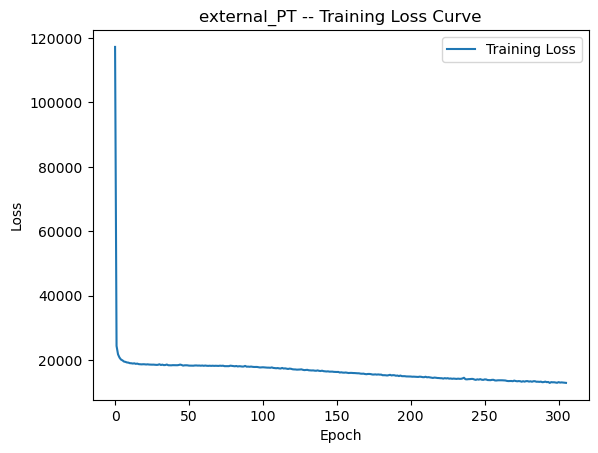

===== Checking external: TAT =====
Iteration 1, loss = 28.74744124
Iteration 2, loss = 9.40338644
Iteration 3, loss = 5.08392706
Iteration 4, loss = 3.45812611
Iteration 5, loss = 2.76205273
Iteration 6, loss = 2.60016512
Iteration 7, loss = 2.24490254
Iteration 8, loss = 1.94601993
Iteration 9, loss = 1.86356355
Iteration 10, loss = 1.74860358
Iteration 11, loss = 1.53431189
Iteration 12, loss = 1.41641254
Iteration 13, loss = 1.36166840
Iteration 14, loss = 1.29076917
Iteration 15, loss = 1.35202361
Iteration 16, loss = 1.19485658
Iteration 17, loss = 1.14850083
Iteration 18, loss = 1.04995108
Iteration 19, loss = 0.99186968
Iteration 20, loss = 0.93568720
Iteration 21, loss = 0.93375576
Iteration 22, loss = 0.92137547
Iteration 23, loss = 0.93217198
Iteration 24, loss = 0.83360459
Iteration 25, loss = 0.92440043
Iteration 26, loss = 0.78405672
Iteration 27, loss = 0.79660104
Iteration 28, loss = 0.74524530
Iteration 29, loss = 0.86782787
Iteration 30, loss = 0.79182344
Iteration 31,

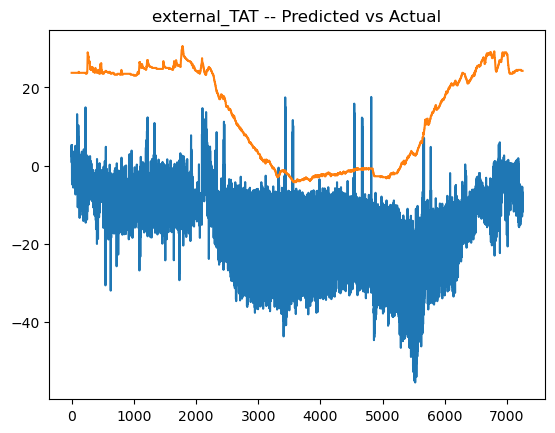

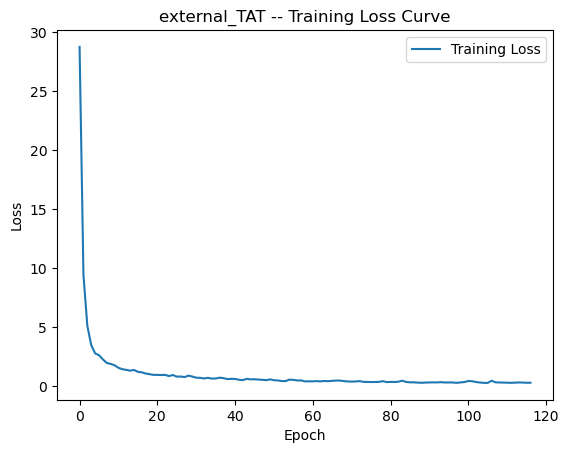

===== Checking external: LOC =====
Iteration 1, loss = 0.05780172
Iteration 2, loss = 0.01686045
Iteration 3, loss = 0.01382043
Iteration 4, loss = 0.01253259
Iteration 5, loss = 0.01178807
Iteration 6, loss = 0.01131210
Iteration 7, loss = 0.01081473
Iteration 8, loss = 0.01042908
Iteration 9, loss = 0.01017000
Iteration 10, loss = 0.00980016
Iteration 11, loss = 0.00957520
Iteration 12, loss = 0.00907243
Iteration 13, loss = 0.00876642
Iteration 14, loss = 0.00860324
Iteration 15, loss = 0.00838712
Iteration 16, loss = 0.00816220
Iteration 17, loss = 0.00773809
Iteration 18, loss = 0.00759838
Iteration 19, loss = 0.00742647
Iteration 20, loss = 0.00728093
Iteration 21, loss = 0.00696571
Iteration 22, loss = 0.00697873
Iteration 23, loss = 0.00670451
Iteration 24, loss = 0.00679176
Iteration 25, loss = 0.00654641
Iteration 26, loss = 0.00643317
Iteration 27, loss = 0.00644188
Iteration 28, loss = 0.00666445
Iteration 29, loss = 0.00615722
Iteration 30, loss = 0.00602664
Iteration 31, 

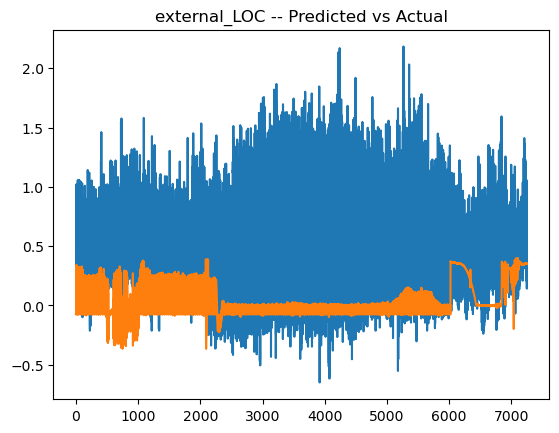

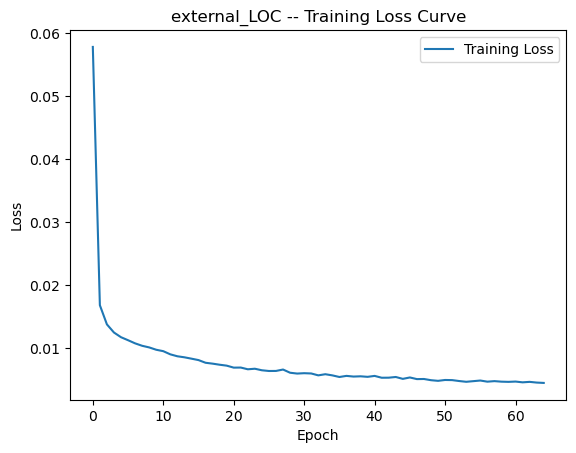

===== Checking recorder: PH =====
Iteration 1, loss = 0.82209434
Iteration 2, loss = 0.14201050
Iteration 3, loss = 0.10470041
Iteration 4, loss = 0.08224320
Iteration 5, loss = 0.07356181
Iteration 6, loss = 0.06762163
Iteration 7, loss = 0.06462168
Iteration 8, loss = 0.06107098
Iteration 9, loss = 0.05053326
Iteration 10, loss = 0.04941867
Iteration 11, loss = 0.04601062
Iteration 12, loss = 0.04249626
Iteration 13, loss = 0.04218270
Iteration 14, loss = 0.03947950
Iteration 15, loss = 0.03843847
Iteration 16, loss = 0.03666812
Iteration 17, loss = 0.03192147
Iteration 18, loss = 0.03649465
Iteration 19, loss = 0.03251788
Iteration 20, loss = 0.03187303
Iteration 21, loss = 0.03055446
Iteration 22, loss = 0.02918282
Iteration 23, loss = 0.02886188
Iteration 24, loss = 0.03025136
Iteration 25, loss = 0.02568404
Iteration 26, loss = 0.02517487
Iteration 27, loss = 0.02627900
Iteration 28, loss = 0.02608854
Iteration 29, loss = 0.02441630
Iteration 30, loss = 0.02437343
Iteration 31, l

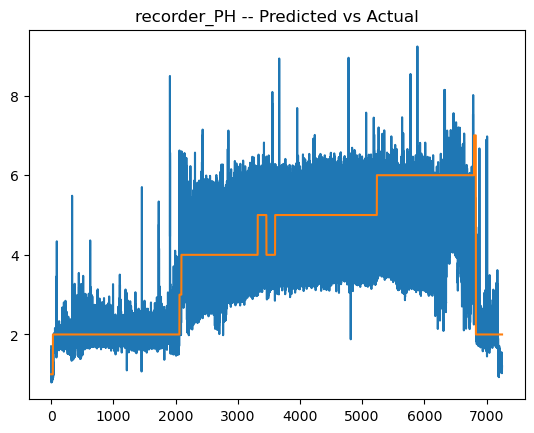

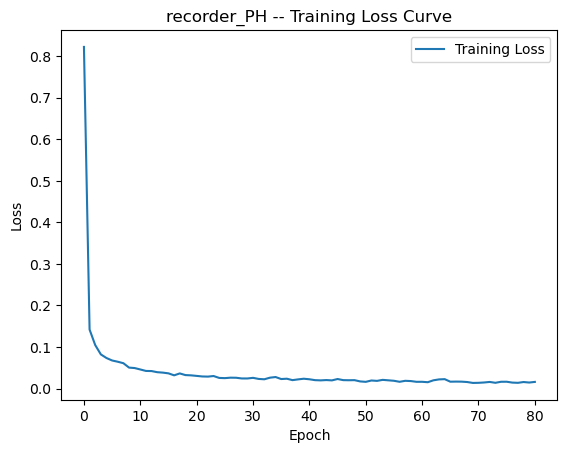

===== Checking unclassified: EVNT =====
Iteration 1, loss = 0.07924755
Iteration 2, loss = 0.02072579
Iteration 3, loss = 0.02226102
Iteration 4, loss = 0.00187222
Iteration 5, loss = 0.00150476
Iteration 6, loss = 0.00113517
Iteration 7, loss = 0.00076520
Iteration 8, loss = 0.00059159
Iteration 9, loss = 0.00049955
Iteration 10, loss = 0.00042476
Iteration 11, loss = 0.00037329
Iteration 12, loss = 0.00034272
Iteration 13, loss = 0.00029686
Iteration 14, loss = 0.00026366
Iteration 15, loss = 0.00024903
Iteration 16, loss = 0.00022762
Iteration 17, loss = 0.00021730
Iteration 18, loss = 0.00019808
Iteration 19, loss = 0.00017461
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -2.1855970172382797


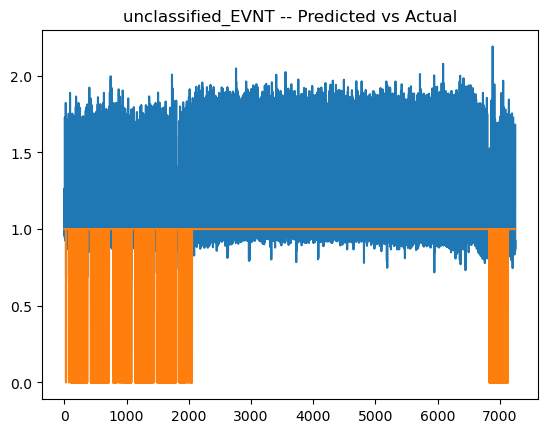

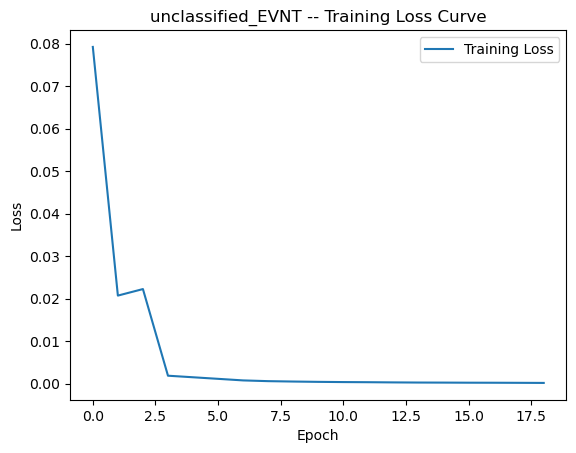

===== Checking unclassified: HF1 =====
Iteration 1, loss = 0.07924755
Iteration 2, loss = 0.02072579
Iteration 3, loss = 0.02226102
Iteration 4, loss = 0.00187222
Iteration 5, loss = 0.00150476
Iteration 6, loss = 0.00113517
Iteration 7, loss = 0.00076520
Iteration 8, loss = 0.00059159
Iteration 9, loss = 0.00049955
Iteration 10, loss = 0.00042476
Iteration 11, loss = 0.00037329
Iteration 12, loss = 0.00034272
Iteration 13, loss = 0.00029686
Iteration 14, loss = 0.00026366
Iteration 15, loss = 0.00024903
Iteration 16, loss = 0.00022762
Iteration 17, loss = 0.00021730
Iteration 18, loss = 0.00019808
Iteration 19, loss = 0.00017461
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： 0.0


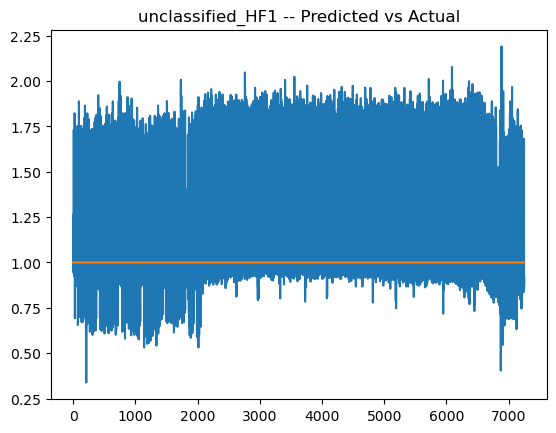

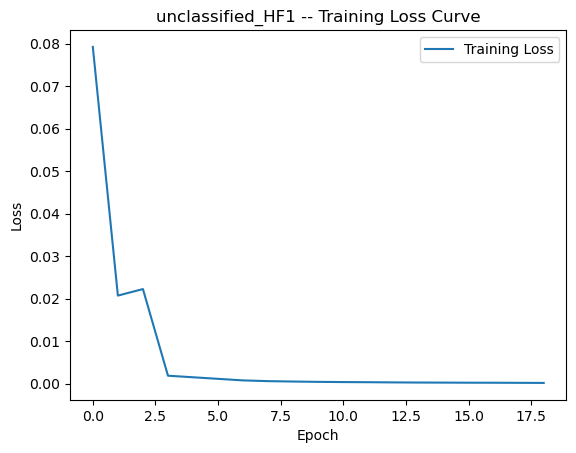

===== Checking unclassified: HF2 =====
Iteration 1, loss = 0.07924755
Iteration 2, loss = 0.02072579
Iteration 3, loss = 0.02226102
Iteration 4, loss = 0.00187222
Iteration 5, loss = 0.00150476
Iteration 6, loss = 0.00113517
Iteration 7, loss = 0.00076520
Iteration 8, loss = 0.00059159
Iteration 9, loss = 0.00049955
Iteration 10, loss = 0.00042476
Iteration 11, loss = 0.00037329
Iteration 12, loss = 0.00034272
Iteration 13, loss = 0.00029686
Iteration 14, loss = 0.00026366
Iteration 15, loss = 0.00024903
Iteration 16, loss = 0.00022762
Iteration 17, loss = 0.00021730
Iteration 18, loss = 0.00019808
Iteration 19, loss = 0.00017461
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： 0.0


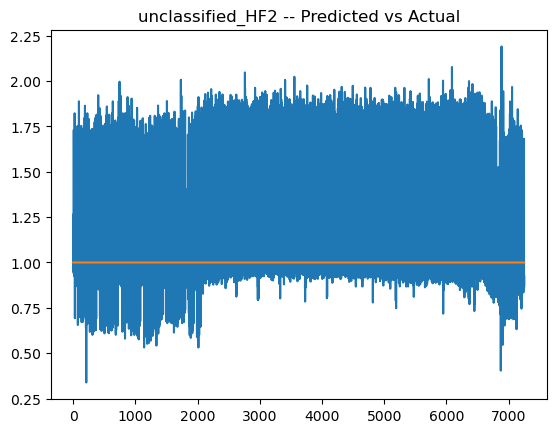

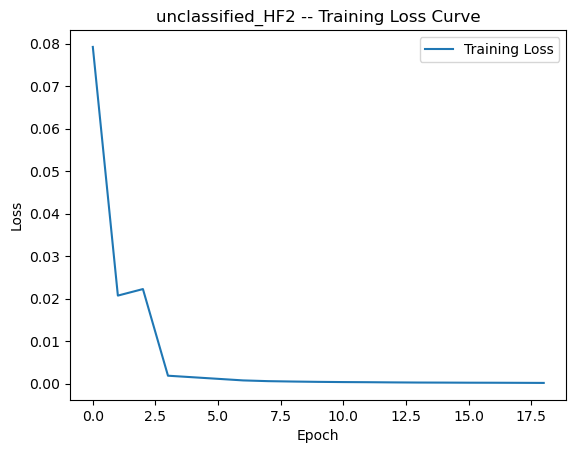

===== Checking unclassified: VHF1 =====
Iteration 1, loss = 0.08704717
Iteration 2, loss = 0.02755325
Iteration 3, loss = 0.03131075
Iteration 4, loss = 0.01016593
Iteration 5, loss = 0.00970228
Iteration 6, loss = 0.00902071
Iteration 7, loss = 0.00857045
Iteration 8, loss = 0.00840557
Iteration 9, loss = 0.00819500
Iteration 10, loss = 0.00793451
Iteration 11, loss = 0.00778819
Iteration 12, loss = 0.00762417
Iteration 13, loss = 0.00762051
Iteration 14, loss = 0.00752904
Iteration 15, loss = 0.00730471
Iteration 16, loss = 0.00712270
Iteration 17, loss = 0.00719469
Iteration 18, loss = 0.00715244
Iteration 19, loss = 0.00702455
Iteration 20, loss = 0.00694583
Iteration 21, loss = 0.00666850
Iteration 22, loss = 0.00691495
Iteration 23, loss = 0.00661057
Iteration 24, loss = 0.00693312
Iteration 25, loss = 0.00626279
Iteration 26, loss = 0.00618643
Iteration 27, loss = 0.00598780
Iteration 28, loss = 0.00622547
Iteration 29, loss = 0.00610610
Iteration 30, loss = 0.00614163
Iteration

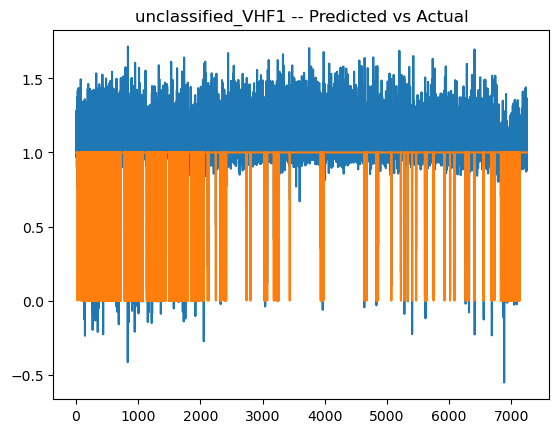

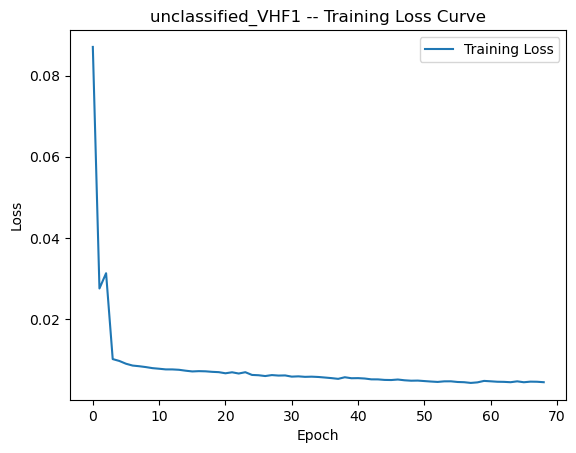

===== Checking unclassified: VHF2 =====
Iteration 1, loss = 0.07871706
Iteration 2, loss = 0.02243962
Iteration 3, loss = 0.02161308
Iteration 4, loss = 0.00249625
Iteration 5, loss = 0.00205342
Iteration 6, loss = 0.00162407
Iteration 7, loss = 0.00136199
Iteration 8, loss = 0.00118236
Iteration 9, loss = 0.00110054
Iteration 10, loss = 0.00100472
Iteration 11, loss = 0.00101739
Iteration 12, loss = 0.00095369
Iteration 13, loss = 0.00086129
Iteration 14, loss = 0.00087107
Iteration 15, loss = 0.00080339
Iteration 16, loss = 0.00086107
Iteration 17, loss = 0.00087916
Iteration 18, loss = 0.00079467
Iteration 19, loss = 0.00076944
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -2.8161330647580223


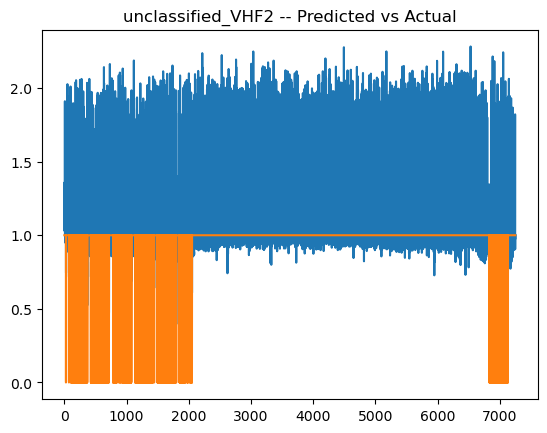

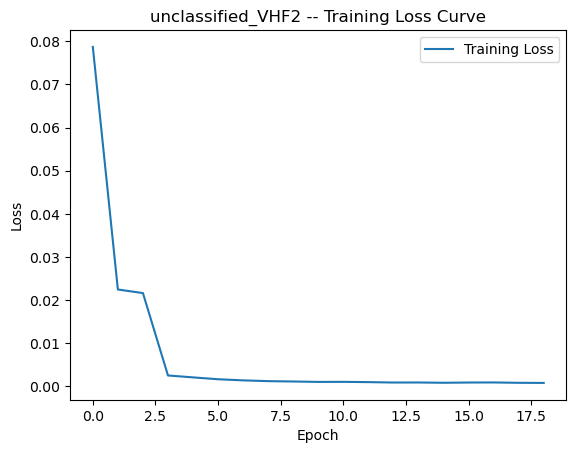

===== Checking unclassified: VHF3 =====
Iteration 1, loss = 0.08092071
Iteration 2, loss = 0.02143470
Iteration 3, loss = 0.02406020
Iteration 4, loss = 0.00299709
Iteration 5, loss = 0.00266772
Iteration 6, loss = 0.00208373
Iteration 7, loss = 0.00177509
Iteration 8, loss = 0.00162481
Iteration 9, loss = 0.00153059
Iteration 10, loss = 0.00147740
Iteration 11, loss = 0.00147062
Iteration 12, loss = 0.00136105
Iteration 13, loss = 0.00135375
Iteration 14, loss = 0.00130930
Iteration 15, loss = 0.00126872
Iteration 16, loss = 0.00124095
Iteration 17, loss = 0.00119245
Iteration 18, loss = 0.00122089
Iteration 19, loss = 0.00120049
Iteration 20, loss = 0.00118077
Iteration 21, loss = 0.00110748
Iteration 22, loss = 0.00110482
Iteration 23, loss = 0.00106481
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： -41.90398164298557


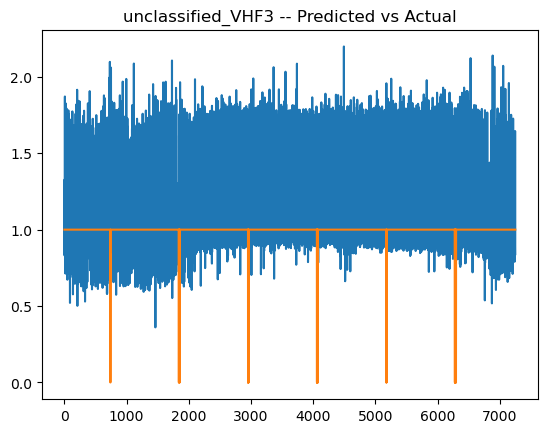

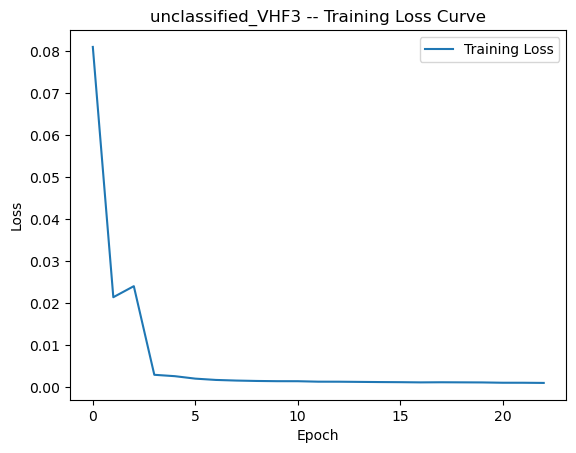

===== Checking unclassified: SMKB =====
Iteration 1, loss = 0.07924755
Iteration 2, loss = 0.02072579
Iteration 3, loss = 0.02226102
Iteration 4, loss = 0.00187222
Iteration 5, loss = 0.00150476
Iteration 6, loss = 0.00113517
Iteration 7, loss = 0.00076520
Iteration 8, loss = 0.00059159
Iteration 9, loss = 0.00049955
Iteration 10, loss = 0.00042476
Iteration 11, loss = 0.00037329
Iteration 12, loss = 0.00034272
Iteration 13, loss = 0.00029686
Iteration 14, loss = 0.00026366
Iteration 15, loss = 0.00024903
Iteration 16, loss = 0.00022762
Iteration 17, loss = 0.00021730
Iteration 18, loss = 0.00019808
Iteration 19, loss = 0.00017461
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train complete
test complete
evaluate complete
模型性能： 0.0


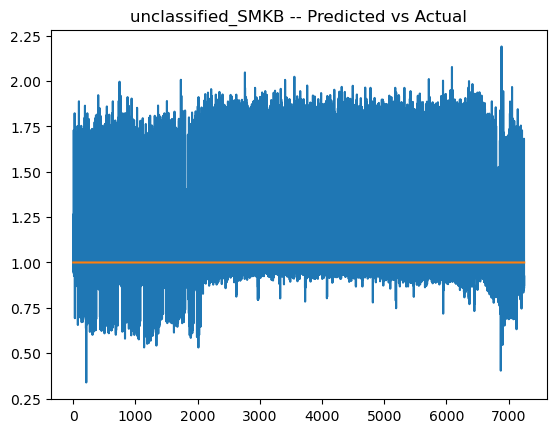

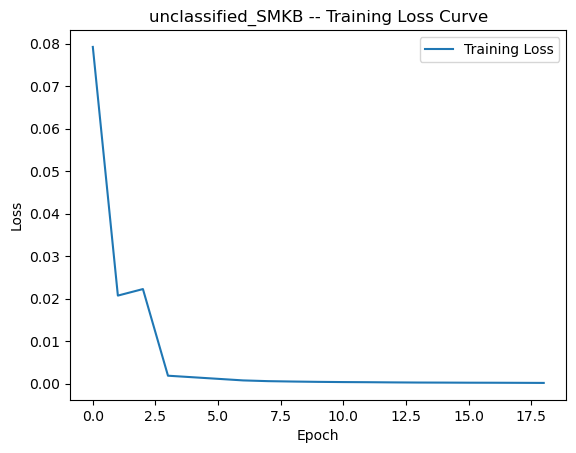

In [9]:
# 构建MLP
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 给定数据存储路径
mlp_save_path = '../result/variable_evaluate/mlp'
if not os.path.exists(mlp_save_path):
    os.mkdir(mlp_save_path)
accuracy_save_path = os.path.join(mlp_save_path, 'accuracy')
loss_save_path = os.path.join(mlp_save_path, 'loss')
if not os.path.exists(accuracy_save_path):
    os.mkdir(accuracy_save_path)
if not os.path.exists(loss_save_path):
    os.mkdir(loss_save_path)

# 初始化数据存储字典
accuracy_dict = {}

# 特征标准化处理
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 创建MLP回归器实例
mlp = MLPRegressor(hidden_layer_sizes = (100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.01, verbose=False)
# mlp_list = []

for i in range(0, train_Y.shape[1]):
    group_name, var_name = find_var_name(i, invalid_var_dict)
    print(f"===== Checking {group_name}: {var_name} =====")

    # # 创建MLP回归器实例
    # mlp = MLPRegressor(hidden_layer_sizes = (100, 50), activation='relu', solver='adam', random_state = 42, max_iter=500, learning_rate='invscaling', learning_rate_init=0.01, verbose=False)
    # mlp_list.append(mlp)

    # 训练模型
    mlp.fit(train_X_scaled, train_Y[:,i])
    loss_values = mlp.loss_curve_
    print("train complete")

    # 测试模型
    y_pred = mlp.predict(test_X_scaled)
    # for i in range(y_pred.shape[1]):
    #     plt.figure()
    #     plt.plot(y_pred[:,i], label='Predicted')
    #     plt.plot(test_Y[:,i], label='Actual')
    #     plt.show()
    print("test complete")

    # 评估模型的性能
    accuracy = mlp.score(test_X_scaled, test_Y[:,i])
    accuracy_dict[var_name] = accuracy
    print("evaluate complete")
    if accuracy > 0.9:
        print(i)
        # 打印模型性能
        print("模型性能：", accuracy)
        plt.figure()
        plt.plot(y_pred, label='Predicted')
        plt.plot(test_Y[:,i], label='Actual')
        plt.title(group_name + '_' + var_name + ' -- Predicted vs Actual')
        plt.savefig(os.path.join(accuracy_save_path, var_name+'_accuracy.png'))
        plt.show()
        # 可视化损失值的变化
        plt.figure()
        plt.plot(loss_values, label='Training Loss')
        plt.title(group_name + '_' + var_name + ' -- Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(loss_save_path, var_name+'_loss.png'))
        plt.show()
    # break

In [10]:
for var_name, accuracy in accuracy_dict.items():
    if accuracy > 0:
        print(var_name, accuracy)

LGDN 0.8206872827070133
PH 0.1609252040888346


In [11]:
# 保存模型
import pickle

mlp_save_path = '../result/variable_evaluate/mlp'

# 将模型保存到文件
filename = os.path.join(mlp_save_path, 'mlp_model.pkl')
pickle.dump(mlp, open(filename, 'wb'))
# for i, mlp in enumerate(mlp_list):
#     group_name, var_name = find_var_name(i)
#     filename = os.path.join(mlp_save_path, 'mlp_model_'+var_name+'.pkl')
#     pickle.dump(mlp, open(filename, 'wb'))

# # 加载模型
# loaded_model = pickle.load(open(filename, 'rb'))

# # 使用加载的模型进行预测
# predictions = loaded_model.predict(test_X)